# Section I: Generating PDFs for distance distribution 

This section illustrated how the PDFs over time in Figure 3. 
Each comparison are also subjected to a stimulated power analysis to guarantee a true significant value. The p value for each comparisons are generated using the Kolmogorov-Smirnov test p-value are also adjusted for multiple comparisons using FDR (Benjamini-Hochberg).  

## Import data and extract distance information. 

In [1]:
import os
import glob
import pandas as pd

def extract_distances_from_folders(base_path, stages):
    """
    Extracts distances (E1-PPE, E2-PPE, and E1-E2) from CSV files across multiple folders for different stages.

    Parameters:
        base_path (str): The base path where the stage folders are located.
        stages (list): A list of folder names (stages) to process (e.g., ['Nc12', 'Nc13']).

    Returns:
        dict: A dictionary containing DataFrames for each distance type ('3'-PPE', '5'-PPE', '3'-5') 
              for each stage.
    """
    result = {}

    for stage in stages:
        # Define the path to the folder containing the CSV files
        folder_path = os.path.join(base_path, stage)

        # Collect and concatenate only CSV files directly in the folder (no subdirectories)
        csv_files = sorted(glob.glob(os.path.join(folder_path, "*.csv")))
        li = []
        for f in csv_files:
            df = pd.read_csv(f)
            li.append(df)

        # Check if there are any CSV files
        if not li:
            print(f"No CSV files found in {folder_path} for stage: {stage}")
            continue

        # Concatenate all DataFrames in the list
        stage_distances = pd.concat(li, axis=0, ignore_index=True)

        # Extract rows where only 'leftDist' is present. Drop NA for subset in leftDist column only. Here, leftDist correspond to E2-PPE distance.
        # This is dependent on which fluorophore you chose to be in the Left box in the find_spots GUI. In this case, 488, which is E2 was chosen 
        # to be on the Left. Henceforth, leftDist is E2-PPE distance. 
        left_dist = stage_distances.dropna(subset=['leftDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'leftDist']
        ].rename(columns={'leftDist': "E2-PPE distance (um)"})

        # Extract rows where only 'rightDist' is present. Drop NA for subset in rightDist column only. This correspond to E1-PPE distance. 
        right_dist = stage_distances.dropna(subset=['rightDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'rightDist']
        ].rename(columns={'rightDist': "E1-PPE distance (um)"})

        # Extract rows where only 'leftRightDist' is present. Drop NA for subset in leftRightDist column only. This correspond to E1-E2 distance. 
        left_right_dist = stage_distances.dropna(subset=['leftRightDist'])[
            ['Xleft', 'Yleft', 'Zleft', 'Xmiddle', 'Ymiddle', 'Zmiddle',
             'Xright', 'Yright', 'Zright', 'leftRightDist']
        ].rename(columns={'leftRightDist': "E1-E2 distance (um)"})

        # Store the DataFrames in the result dictionary
        result[f'{stage}_E2-PPE'] = left_dist
        result[f'{stage}_E1-PPE'] = right_dist
        result[f'{stage}_E1-E2'] = left_right_dist

    return result

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Loading wild-type data
base_path = '../../../../10_03_SR_T3_2_doublets_2_thres/YW_distances/'
stages = ['Nc12/Male', 'Nc13/Male', 'Nc14_early/Male','Nc14_late/Male']

distance_data = extract_distances_from_folders(base_path, stages)

# Accessing the results for Nc12
YW_E2_PPE_nc12 = distance_data['Nc12/Male_E2-PPE']
YW_E1_PPE_nc12 = distance_data['Nc12/Male_E1-PPE']
YW_E1_E2_nc12 = distance_data['Nc12/Male_E1-E2']

# Accessing the results for Nc13
YW_E2_PPE_nc13 = distance_data['Nc13/Male_E2-PPE']
YW_E1_PPE_nc13 = distance_data['Nc13/Male_E1-PPE']
YW_E1_E2_nc13 = distance_data['Nc13/Male_E1-E2']

# Accessing the results for Nc14_early
YW_E2_PPE_nc14_early = distance_data['Nc14_early/Male_E2-PPE']
YW_E1_PPE_nc14_early = distance_data['Nc14_early/Male_E1-PPE']
YW_E1_E2_nc14_early = distance_data['Nc14_early/Male_E1-E2']

# Accessing the results for Nc14_late
YW_E2_PPE_nc14_late = distance_data['Nc14_late/Male_E2-PPE']
YW_E1_PPE_nc14_late = distance_data['Nc14_late/Male_E1-PPE']
YW_E1_E2_nc14_late = distance_data['Nc14_late/Male_E1-E2']

## Plotting PDFs for distance distributions:

In [3]:
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import bokeh.io
bokeh.io.output_notebook()
from bokeh.models import Legend
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import matplotlib.patches as patches
from bokeh.plotting import figure, show
from bokeh.layouts import row
import iqplot
from bokeh.models import ColumnDataSource, HoverTool, Range1d, Legend, LegendItem
from bokeh.io import output_notebook  # Import for inline display


def generate_plots(dataframes, distance_column, phenotype_label, x_axis_label=None):
    """ This generate two different plots side-by-side: strip box plot (left) and PDF (right). Here, we are plotting visualization for all four stages 
    for a specific pairwise distance. 
    For the strip-box plot, we use swarm layout for points clarity.
    PDF is generated using KDE of distances per stage. PDF is generated through scipy.stats Gaussian Kernel Density Estimation (gaussian_kde) which is a 
    non-parametric way of visualizing all distances per stage without assuming any underlying distribution. This allows us to have a "smooth histogram" 
    to identify peaks, median and overall shape of the distance distribution. In the PDF, median line is also plotted. The x value for the peak of 
    each PDF is also outputted.
    """
    # Convert the DataFrame columns to Numpy arrays
    arrays = [df[distance_column].to_numpy() for df in dataframes]
    
    # Stages over time and color palette
    stages_labels = ['Pre-nc13', 'nc13', 'nc14-early', 'nc14-late']
    palette = ['red','#FF00FF','#3F7FFF','#00008B',]  # Light blue, neon blue, dark blue
    
    #Create dataframe for combining distances dynamically using passed 
    #distance column. 
    df_combined = pd.DataFrame({
        "phenotype": [phenotype_label] * sum(len(arr) for arr in arrays),
        distance_column: np.concatenate(arrays),  # Use the dynamic distance_column name
        "stages": np.concatenate([[stages_labels[i]] * len(arr) for i, arr in enumerate(arrays)])
    })

    label_to_use = x_axis_label if x_axis_label else distance_column
    
    # Create strip-box plot using iqplot with jitter spread
    strip_box_plot = iqplot.stripbox(
        df_combined,
        q=distance_column,  # Use the dynamic distance column
        cats="stages",
        title=f"{phenotype_label} \nDistance between {label_to_use} over time",  # Dynamic title
        x_axis_label=label_to_use,  # Dynamic x-axis label
        y_axis_label="Developmental Stages",
        frame_height=500,
        spread='swarm',  # Avoid exceeding max height
        palette=palette
    )
    
    # Dictionary to store the x-value of the peak for each stage
    pdf_peaks = {}
    
    # Create the PDF plot using Bokeh
    pdf_plot = figure(
        title=f"{phenotype_label} \nDistance between {label_to_use} over time",
        x_axis_label=label_to_use, # Dynamic x axis label. 
        y_axis_label="Probability Density",
        height=600, 
        width=1000
    )
    
    # Correct the x-axis label format
    micrometer_symbol = "μm"
    formatted_distance_label = distance_column.replace("(um)", f"({micrometer_symbol})")
    pdf_plot.xaxis.axis_label = label_to_use
    
    # Customize title and axes for boldness and larger font sizes
    pdf_plot.title.text_font_size = "13pt"  # Larger font for the title
    pdf_plot.title.align = "center"  # Center align the title
    pdf_plot.axis.axis_label_text_font_size = "25pt"  # Larger font size for axis labels
    pdf_plot.axis.axis_label_text_font_style = "bold"  # Bold axis labels
    pdf_plot.axis.major_label_text_font_size = "18pt"  # Larger font size for tick labels
    pdf_plot.axis.major_label_text_font_style = "bold"  # Bold tick labels
    pdf_plot.axis.axis_line_width = 2  # Thicker axis lines
    pdf_plot.axis.axis_line_color = "black"  # Darker axis lines for emphasis
    pdf_plot.axis.major_tick_line_width = 3  # Thicker major ticks
    pdf_plot.axis.major_tick_line_color = "black"  # Darker major ticks
    pdf_plot.axis.minor_tick_line_width = 2  # Optionally thicker minor ticks
    pdf_plot.axis.minor_tick_line_color = "black"  # Optionally make minor ticks visible
    pdf_plot.title.standoff = 20  # Move the title higher from the graph (adjust as needed)
    # Set the y-axis range to be from 0 to 2
    pdf_plot.y_range = Range1d(start=0, end=2.2)
    
    # Initialize legend items: 
    legend_items = []

    # Iterate through each stage to plot the PDF and confidence intervals
    n_bootstraps = 1000  # Number of bootstrap samples for confidence intervals
    for i, stage in enumerate(stages_labels):
        # Get data for the current stage
        stage_data = arrays[i]

        # Calculate sample size and median
        n_samples = len(stage_data)
        median_value = np.median(stage_data)

        # Estimate KDE (PDF) for the current stage
        kde = gaussian_kde(stage_data)
        x_range = np.linspace(stage_data.min(), stage_data.max(), 100)
        y_kde = kde(x_range)

        # Normalize the densities
        y_kde /= np.trapz(y_kde, x_range)  # Normalize PDF
        
        # Find the x-value of the peak
        peak_x_value = x_range[np.argmax(y_kde)]
        pdf_peaks[f"PDF_{stage.replace(' ', '_')}"] = peak_x_value  # Save peak x-value with stage-specific name

        # Bootstrapping for confidence intervals
        bootstrapped_y = np.zeros((n_bootstraps, len(x_range)))
        for b in range(n_bootstraps):
            bootstrap_sample = np.random.choice(stage_data, size=len(stage_data), replace=True)
            bootstrapped_kde = gaussian_kde(bootstrap_sample)
            bootstrapped_y[b] = bootstrapped_kde(x_range)

        # Calculate confidence intervals
        ci_lower = np.percentile(bootstrapped_y, 2.5, axis=0)
        ci_upper = np.percentile(bootstrapped_y, 97.5, axis=0)

        # Create ColumnDataSource for interactive plotting
        source_pdf = ColumnDataSource(data={'x': x_range, 'y': y_kde, 'ci_upper': ci_upper, 'ci_lower': ci_lower})

        # Plot the PDF curve with n and median in the legend label
        line = pdf_plot.line(
            'x', 'y', source=source_pdf, line_width=4, color=palette[i], 
            legend_label=f"{stage} (n={n_samples}, median={median_value:.2f})"
        )

        # Plot the confidence intervals as shaded area with the same legend label
        ci = pdf_plot.varea(
            x='x', y1='ci_lower', y2='ci_upper', source=source_pdf, fill_alpha=0.2, fill_color=palette[i], 
                       legend_label=f"{stage} (n={n_samples}, median={median_value:.2f})"
            
        )
        
        # Define the vertical range for the median line (shorter range)
        y_min = 0.05 * max(y_kde)  # 5% of max density (adjust as needed)
        y_max = 0.90 * max(y_kde)  # 90% of max density
        
        # ** Plot median as vertical line**
        median_line = pdf_plot.line(
            [median_value, median_value], [0,y_max], 
            line_color = palette[i], line_width=3, line_dash="dotdash",line_alpha=0.4
        )
        
        # Add stage to legend items, including line and CI:
        legend_items.append(
            LegendItem(label=f"{stage}(n={n_samples}, median={median_value:.2f})", renderers=[line,ci])
        )

        # Add hover tool for the PDF and confidence intervals
        hover = HoverTool(
            renderers=[pdf_plot.renderers[-1]],  # Attach hover to the curve and confidence intervals
            tooltips=[
                ("X-axis", "@x"),
                ("Density", "@y"),
                ("Confidence Interval", "(@ci_lower, @ci_upper)")
            ]
        )
        pdf_plot.add_tools(hover)

    # Explicitly remove the default legend
    pdf_plot.legend.visible = False
    pdf_plot.legend.items = []  # Completely remove the default legend

    # Move legend outside of the plot
    legend = Legend(items=legend_items, location="center")
    legend.label_text_font_size = "10pt"
    pdf_plot.add_layout(legend,'right')
    pdf_plot.legend.click_policy = "hide"  # Allow toggling the visibility of the curve and confidence intervals
    
    # Display plots side by side
    show(row(strip_box_plot, pdf_plot))
    
    # Return the dictionary with peak x-values
    return pdf_peaks

Loading BokehJS ...

In [4]:
### Comparison PDFs for E1-PPE distances over time.
generate_plots(
    dataframes=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    distance_column="E1-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="wild-type control",
    x_axis_label="E1-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 132 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 156 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 226 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


{'PDF_Pre-nc13': 0.28258606995208363,
 'PDF_nc13': 0.24134326221540486,
 'PDF_nc14-early': 0.24109708520891032,
 'PDF_nc14-late': 0.24152750392964725}

In [5]:
### Comparison PDFs for E2-PPE distances over time.
generate_plots(
    dataframes=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    distance_column="E2-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="wild-type control",
    x_axis_label="E2-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 2 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 5 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 22 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


{'PDF_Pre-nc13': 0.2996304935809435,
 'PDF_nc13': 0.30324824598400607,
 'PDF_nc14-early': 0.31264066078700276,
 'PDF_nc14-late': 0.3412490853162714}

In [6]:
### Comparison PDFs for E1-E2 distances over time.
generate_plots(
    dataframes=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    distance_column="E1-E2 distance (um)", # Column corresponds to E1-E2
    phenotype_label="wild-type control",
    x_axis_label="E1-E2 (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 2 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 19 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


{'PDF_Pre-nc13': 0.3224731485159289,
 'PDF_nc13': 0.3108981814920762,
 'PDF_nc14-early': 0.29940021719844095,
 'PDF_nc14-late': 0.3122249459020162}

In [7]:
base_path = '../../../../10_03_SR_T3_2_doublets_2_thres/PPE_distances/'
stages = ['Nc12/Male', 'Nc13/Male', 'Nc14_early/Male','Nc14_late/Male']

distance_data = extract_distances_from_folders(base_path, stages)

# Accessing the results for Nc12
PPE_E2_PPE_nc12 = distance_data['Nc12/Male_E2-PPE']
PPE_E1_PPE_nc12 = distance_data['Nc12/Male_E1-PPE']
PPE_E1_E2_nc12 = distance_data['Nc12/Male_E1-E2']

# Accessing the results for Nc13
PPE_E2_PPE_nc13 = distance_data['Nc13/Male_E2-PPE']
PPE_E1_PPE_nc13 = distance_data['Nc13/Male_E1-PPE']
PPE_E1_E2_nc13 = distance_data['Nc13/Male_E1-E2']

# Accessing the results for Nc14_early
PPE_E2_PPE_nc14_early = distance_data['Nc14_early/Male_E2-PPE']
PPE_E1_PPE_nc14_early = distance_data['Nc14_early/Male_E1-PPE']
PPE_E1_E2_nc14_early = distance_data['Nc14_early/Male_E1-E2']

# Accessing the results for Nc14_late
PPE_E2_PPE_nc14_late = distance_data['Nc14_late/Male_E2-PPE']
PPE_E1_PPE_nc14_late = distance_data['Nc14_late/Male_E1-PPE']
PPE_E1_E2_nc14_late = distance_data['Nc14_late/Male_E1-E2']

In [8]:
generate_plots(
    [PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    distance_column="E1-PPE distance (um)", # Column corresponds to E1-PPE
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E1-PPE (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 1 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 79 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 39 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(
/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 87 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


{'PDF_Pre-nc13': 0.2365619526749394,
 'PDF_nc13': 0.26247426174443433,
 'PDF_nc14-early': 0.22333677213917869,
 'PDF_nc14-late': 0.20181714966313502}

In [9]:
generate_plots(
    [PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    distance_column="E2-PPE distance (um)", # Column corresponds to E2-PPE
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E2-PPE (μm)"  # Custom label shown in plot
)

{'PDF_Pre-nc13': 0.35997353434612267,
 'PDF_nc13': 0.38021537110612985,
 'PDF_nc14-early': 0.3220987598282876,
 'PDF_nc14-late': 0.3269943636114892}

In [10]:
generate_plots(
    [PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    distance_column="E1-E2 distance (um)", # Column corresponds to E1-E2
    phenotype_label="Δ800bp PPE mutant",
    x_axis_label="E1-E2 (μm)"  # Custom label shown in plot
)

/Users/minhtamninale/opt/anaconda3/envs/bootcamp/lib/python3.11/site-packages/iqplot/cat.py:1771: UserWarning: 3 data points exceed maximum height. Consider using spread='jitter' or increasing the frame height.
  warnings.warn(


{'PDF_Pre-nc13': 0.343901442786262,
 'PDF_nc13': 0.3025840216764682,
 'PDF_nc14-early': 0.2914563975584258,
 'PDF_nc14-late': 0.27824076818971294}

# Section II: Retrieving p-value for multiple over time comparisons.

Using Kolmogorov Smirnov test to get p-value for the comparison over time. Benjamini Hochberg (FDR) is utilized to adjust for multiple comparisons.

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

def perform_ks_tests(dataframes, labels, distance_column, alpha=0.05):
    """
    Perform K-S tests between different stages based on a specified distance column,
    apply Benjamini-Hochberg (FDR) correction, and return results in a DataFrame with rankings.
    
    Parameters:
    - dataframes: List of DataFrames containing distance data for each stage.
    - labels: List of labels corresponding to each DataFrame.
    - distance_column: The name of the column to perform the K-S tests on.
    - alpha: False Discovery Rate (FDR) threshold for significance.
    
    Returns:
    - results_df: DataFrame containing K-S test results with FDR rankings.
    """
    results = []
    p_values = []
    comparisons = []

    # Loop over each pair of DataFrames
    for i in range(len(dataframes)):
        for j in range(i + 1, len(dataframes)):
            # Select the distance data from the specified column
            data1 = dataframes[i][distance_column].dropna()  # Remove NaN values
            data2 = dataframes[j][distance_column].dropna()  # Remove NaN values
            
            # Perform K-S test
            D_statistic, p_value = ks_2samp(data1, data2)
            comparison = f"{labels[i]} vs {labels[j]}"
            comparisons.append(comparison)
            p_values.append(p_value)
            results.append([comparison, D_statistic, p_value])
    
    # Convert p-values to numpy array for sorting
    p_values = np.array(p_values)
    
    # Apply Benjamini-Hochberg (FDR) correction
    corrected_p_values = multipletests(p_values, method='fdr_bh')[1]

    # Sort p-values and apply original Benjamini-Hochberg ranking method
    sorted_indices = np.argsort(p_values)  # Sort indices by ascending p-values
    num_tests = len(p_values)
    
    fdr_significance = np.full(num_tests, "No")  # Default: not significant
    fdr_thresholds = np.zeros(num_tests)  # Store FDR thresholds for reference
    ranks = np.zeros(num_tests)  # Store ranks for each p-value
    
    for rank, idx in enumerate(sorted_indices, start=1):
        fdr_threshold = (rank / num_tests) * alpha
        fdr_thresholds[idx] = fdr_threshold  # Store threshold for reference
        ranks[idx] = rank  # Store the rank
        
        if p_values[idx] <= fdr_threshold:
            fdr_significance[idx] = "Yes"

    # Add corrected p-values, FDR thresholds, ranks, and significance assessments
    for idx, (comparison, D_statistic, p_value) in enumerate(results):
        corrected_significance = "Yes" if corrected_p_values[idx] < alpha else "No"
        results[idx] = [
            comparison, 
            D_statistic, 
            p_value, 
            corrected_p_values[idx], 
            corrected_significance, 
            fdr_thresholds[idx], 
            ranks[idx], 
            fdr_significance[idx]
        ]
    
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=[
        "Comparison", "D Statistic", "P-value", "Corrected P-value", 
        "Corrected Sig.", "FDR Threshold", "Rank", "FDR Sig."
    ])
    
    return results_df

In [12]:
# p-value comparison over time for E1-PPE pairwise distances
distance_dataframes_E1_PPE = [YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late]
labels_E1_PPE = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [13]:
YW_ks_results_E1_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
YW_ks_results_E1_PPE

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.168561,0.000092,0.000276,Yes,0.016667,2.0,Ye
1,Before nc13 vs nc14 early,0.168340,0.000079,0.000276,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.143027,0.000815,0.001629,Yes,0.025000,3.0,Ye
3,nc13 vs nc14 early,0.044126,0.596413,0.596413,No,0.050000,6.0,No
4,nc13 vs nc14 late,0.055000,0.263206,0.315848,No,0.041667,5.0,No
5,nc14 early vs nc14 late,0.055889,0.229928,0.315848,No,0.033333,4.0,No


In [14]:
# p-value comparison over time for E2-PPE pairwise distances
distance_dataframes_E2_PPE = [YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late]
labels_E2_PPE = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [15]:
YW_ks_results_E2_PPE = perform_ks_tests(distance_dataframes_E2_PPE, labels_E2_PPE, "E2-PPE distance (um)")
YW_ks_results_E2_PPE

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.232340,3.924715e-05,8.315617e-05,Yes,0.016667,2.0,Ye
1,Before nc13 vs nc14 early,0.280712,1.600646e-07,9.603877e-07,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.218744,4.157808e-05,8.315617e-05,Yes,0.025000,3.0,Ye
3,nc13 vs nc14 early,0.101597,8.699602e-02,1.304940e-01,No,0.033333,4.0,No
4,nc13 vs nc14 late,0.073492,3.061523e-01,3.201691e-01,No,0.041667,5.0,No
5,nc14 early vs nc14 late,0.070681,3.201691e-01,3.201691e-01,No,0.050000,6.0,No


In [16]:
# p-value comparison over time for E1-E2 pairwise distances
distance_dataframes_E1_E2 = [YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late]
labels_E1_E2 = [
    "Before nc13",
    "nc13",
    "nc14 early",
    "nc14 late",
]

In [17]:
YW_ks_results_E1_E2 = perform_ks_tests(distance_dataframes_E1_E2, labels_E1_E2, "E1-E2 distance (um)")
YW_ks_results_E1_E2

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.125964,0.092870,0.139305,No,0.033333,4.0,No
1,Before nc13 vs nc14 early,0.206055,0.000564,0.003385,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.081393,0.456040,0.501756,No,0.041667,5.0,No
3,nc13 vs nc14 early,0.113994,0.048780,0.097561,No,0.025000,3.0,No
4,nc13 vs nc14 late,0.062688,0.501756,0.501756,No,0.050000,6.0,No
5,nc14 early vs nc14 late,0.135896,0.003521,0.010564,Yes,0.016667,2.0,Ye


In [18]:
PPE_ks_results_E1_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E1_PPE

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.168561,0.000092,0.000276,Yes,0.016667,2.0,Ye
1,Before nc13 vs nc14 early,0.168340,0.000079,0.000276,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.143027,0.000815,0.001629,Yes,0.025000,3.0,Ye
3,nc13 vs nc14 early,0.044126,0.596413,0.596413,No,0.050000,6.0,No
4,nc13 vs nc14 late,0.055000,0.263206,0.315848,No,0.041667,5.0,No
5,nc14 early vs nc14 late,0.055889,0.229928,0.315848,No,0.033333,4.0,No


In [19]:
PPE_ks_results_E2_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E2_PPE

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.168561,0.000092,0.000276,Yes,0.016667,2.0,Ye
1,Before nc13 vs nc14 early,0.168340,0.000079,0.000276,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.143027,0.000815,0.001629,Yes,0.025000,3.0,Ye
3,nc13 vs nc14 early,0.044126,0.596413,0.596413,No,0.050000,6.0,No
4,nc13 vs nc14 late,0.055000,0.263206,0.315848,No,0.041667,5.0,No
5,nc14 early vs nc14 late,0.055889,0.229928,0.315848,No,0.033333,4.0,No


In [20]:
PPE_ks_results_E3_PPE = perform_ks_tests(distance_dataframes_E1_PPE, labels_E1_PPE, "E1-PPE distance (um)")
PPE_ks_results_E3_PPE

,Comparison,D Statistic,P-value,Corrected P-value,Corrected Sig.,FDR Threshold,Rank,FDR Sig.
0,Before nc13 vs nc13,0.168561,0.000092,0.000276,Yes,0.016667,2.0,Ye
1,Before nc13 vs nc14 early,0.168340,0.000079,0.000276,Yes,0.008333,1.0,Ye
2,Before nc13 vs nc14 late,0.143027,0.000815,0.001629,Yes,0.025000,3.0,Ye
3,nc13 vs nc14 early,0.044126,0.596413,0.596413,No,0.050000,6.0,No
4,nc13 vs nc14 late,0.055000,0.263206,0.315848,No,0.041667,5.0,No
5,nc14 early vs nc14 late,0.055889,0.229928,0.315848,No,0.033333,4.0,No


# Section III: Power analysis to make sure we have enough data

Power analysis to make sure we have enough data for significance differences. Here, we performed a stimulation-based power-analysis through the K-S test to determine the data size you'll need for detecting a statistically significance difference between 2 samples with desired power of 80%.

In [21]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def perform_ks_test_lognormal(n, median1, sigma1, median2, sigma2, alpha=0.01):
    """ Lognormal stimulation using median and standard deviation. Log-normal stimulation was chosen because distance data is 
    strictly positive, has a peak near zero and right skewed with long right tail. Hence, it is good to use this model to stimulate 
    our data for power analysis. """
    
    sample1 = np.random.lognormal(np.log(median1), sigma1, n)
    sample2 = np.random.lognormal(np.log(median2), sigma2, n)
    ks_stat, p_value = stats.ks_2samp(sample1, sample2)
    return p_value < alpha

def power_analysis(sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, 
                   alpha=0.05, desired_power=0.8, max_n=1000, num_simulations=1000):
    """ This is the stimulation based power-analysis for each comparison using log-normal stimulations. """
    sample_sizes = np.arange(10, max_n, 10)
    power = []

    for n in sample_sizes:
        successes = sum(
            perform_ks_test_lognormal(n, mu1, sigma1, mu2, sigma2, alpha) 
            for _ in range(num_simulations)
        )
        power_value = successes / num_simulations
        power.append(power_value)

        if power_value >= desired_power:
            print(
                f"Desired power of {desired_power} between {sample1_name} and {sample2_name}"
                f" for {distance} achieved at sample size {n}."
            )
            break

def combined_power_analysis(analyses):
    """ Wrapper function to allow comparison multiple times. """
    for analysis in analyses:
        sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, alpha, desired_power, max_n, num_simulations = analysis
        power_analysis(sample1_name, mu1, sigma1, sample2_name, mu2, sigma2, distance, 
                       alpha, desired_power, max_n, num_simulations)

In [22]:
YW_nc12_median_E1_PPE = np.median(YW_E1_PPE_nc12["E1-PPE distance (um)"])
YW_nc13_median_E1_PPE = np.median(YW_E1_PPE_nc13["E1-PPE distance (um)"])
YW_nc14_early_median_E1_PPE = np.median(YW_E1_PPE_nc14_early["E1-PPE distance (um)"])
YW_nc14_late_median_E1_PPE = np.median(YW_E1_PPE_nc14_late["E1-PPE distance (um)"])

YW_nc12_std_E1_PPE = np.std(YW_E1_PPE_nc12["E1-PPE distance (um)"])
YW_nc13_std_E1_PPE = np.std(YW_E1_PPE_nc13["E1-PPE distance (um)"])
YW_nc14_early_std_E1_PPE = np.std(YW_E1_PPE_nc14_early["E1-PPE distance (um)"])
YW_nc14_late_std_E1_PPE = np.std(YW_E1_PPE_nc14_late["E1-PPE distance (um)"])

In [23]:
analyses = [
    ("Before nc13", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc13", YW_nc13_median_E1_PPE, YW_nc13_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc12", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc14_early", YW_nc14_early_median_E1_PPE, YW_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E1_PPE, YW_nc12_std_E1_PPE, "Nc14_late", YW_nc14_late_median_E1_PPE, YW_nc14_late_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000)
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc13 for E1 - PPE (um) achieved at sample size 120.
Desired power of 0.8 between Before nc12 and Nc14_early for E1 - PPE (um) achieved at sample size 100.
Desired power of 0.8 between Before nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 180.


In [24]:
YW_nc12_median_E2_PPE = np.median(YW_E2_PPE_nc12["E2-PPE distance (um)"])
YW_nc13_median_E2_PPE = np.median(YW_E2_PPE_nc13["E2-PPE distance (um)"])
YW_nc14_early_median_E2_PPE = np.median(YW_E2_PPE_nc14_early["E2-PPE distance (um)"])
YW_nc14_late_median_E2_PPE = np.median(YW_E2_PPE_nc14_late["E2-PPE distance (um)"])

YW_nc12_std_E2_PPE = np.std(YW_E2_PPE_nc12["E2-PPE distance (um)"])
YW_nc13_std_E2_PPE = np.std(YW_E2_PPE_nc13["E2-PPE distance (um)"])
YW_nc14_early_std_E2_PPE = np.std(YW_E2_PPE_nc14_early["E2-PPE distance (um)"])
YW_nc14_late_std_E2_PPE = np.std(YW_E2_PPE_nc14_late["E2-PPE distance (um)"])

In [25]:
analyses = [
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc13", YW_nc13_median_E2_PPE, YW_nc13_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc14_early", YW_nc14_early_median_E2_PPE, YW_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", YW_nc12_median_E2_PPE, YW_nc12_std_E2_PPE, "Nc14_late", YW_nc14_late_median_E2_PPE, YW_nc14_late_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
]
# Run the combined power analysis
results_df = combined_power_analysis(analyses)
# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc13 for E2 - PPE (um) achieved at sample size 30.
Desired power of 0.8 between Before nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 20.
Desired power of 0.8 between Before nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 30.


In [26]:
YW_nc12_median_E1_E2 = np.median(YW_E1_E2_nc12["E1-E2 distance (um)"])
YW_nc13_median_E1_E2 = np.median(YW_E1_E2_nc13["E1-E2 distance (um)"])
YW_nc14_early_median_E1_E2 = np.median(YW_E1_E2_nc14_early["E1-E2 distance (um)"])
YW_nc14_late_median_E1_E2 = np.median(YW_E1_E2_nc14_late["E1-E2 distance (um)"])

YW_nc12_std_E1_E2 = np.std(YW_E1_E2_nc12["E1-E2 distance (um)"])
YW_nc13_std_E1_E2 = np.std(YW_E1_E2_nc13["E1-E2 distance (um)"])
YW_nc14_early_std_E1_E2 = np.std(YW_E1_E2_nc14_early["E1-E2 distance (um)"])
YW_nc14_late_std_E1_E2 = np.std(YW_E1_E2_nc14_late["E1-E2 distance (um)"])

In [27]:
analyses = [("nc13", YW_nc13_median_E1_E2, YW_nc13_std_E1_E2, "Nc14_early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
            ("Before nc13", YW_nc12_median_E1_E2, YW_nc12_std_E1_E2, "Nc14_early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
            ("nc14 early", YW_nc14_early_median_E1_E2, YW_nc14_early_std_E1_E2, "Nc14_late", YW_nc14_late_median_E1_E2, YW_nc14_late_std_E1_E2, "E1_E2 distance (um)", 0.05, 0.8, 1000, 1000),
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between nc13 and Nc14_early for E1_E2 distance (um) achieved at sample size 200.
Desired power of 0.8 between Before nc13 and Nc14_early for E1_E2 distance (um) achieved at sample size 40.
Desired power of 0.8 between nc14 early and Nc14_late for E1_E2 distance (um) achieved at sample size 120.


In [28]:
PPE_nc12_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc12["E1-PPE distance (um)"])
PPE_nc13_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc13["E1-PPE distance (um)"])
PPE_nc14_early_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc14_early["E1-PPE distance (um)"])
PPE_nc14_late_median_PPE_E1_PPE = np.median(PPE_E1_PPE_nc14_late["E1-PPE distance (um)"])

PPE_nc12_std_E1_PPE = np.std(PPE_E1_PPE_nc12["E1-PPE distance (um)"])
PPE_nc13_std_E1_PPE = np.std(PPE_E1_PPE_nc13["E1-PPE distance (um)"])
PPE_nc14_early_std_E1_PPE = np.std(PPE_E1_PPE_nc14_early["E1-PPE distance (um)"])
PPE_nc14_late_std_E1_PPE = np.std(PPE_E1_PPE_nc14_late["E1-PPE distance (um)"])

In [29]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E1_PPE, PPE_nc12_std_E1_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E1_PPE, PPE_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E1_PPE, PPE_nc12_std_E1_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E1_PPE, PPE_nc14_late_std_E1_PPE , "E1 - PPE (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E1_PPE, PPE_nc13_std_E1_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E1_PPE, PPE_nc14_early_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E1_PPE, PPE_nc13_std_E1_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E1_PPE, PPE_nc14_late_std_E1_PPE, "E1 - PPE (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E1 - PPE (um) achieved at sample size 80.
Desired power of 0.8 between Before nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 50.
Desired power of 0.8 between nc13 and Nc14_early for E1 - PPE (um) achieved at sample size 140.
Desired power of 0.8 between nc13 and Nc14_late for E1 - PPE (um) achieved at sample size 70.


In [30]:
PPE_nc12_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc12["E2-PPE distance (um)"])
PPE_nc13_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc13["E2-PPE distance (um)"])
PPE_nc14_early_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc14_early["E2-PPE distance (um)"])
PPE_nc14_late_median_PPE_E2_PPE = np.median(PPE_E2_PPE_nc14_late["E2-PPE distance (um)"])

PPE_nc12_std_E2_PPE = np.std(PPE_E2_PPE_nc12["E2-PPE distance (um)"])
PPE_nc13_std_E2_PPE = np.std(PPE_E2_PPE_nc13["E2-PPE distance (um)"])
PPE_nc14_early_std_E2_PPE = np.std(PPE_E2_PPE_nc14_early["E2-PPE distance (um)"])
PPE_nc14_late_std_E2_PPE = np.std(PPE_E2_PPE_nc14_late["E2-PPE distance (um)"])

In [31]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E2_PPE, PPE_nc12_std_E2_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E2_PPE, PPE_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E2_PPE, PPE_nc12_std_E2_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E2_PPE, PPE_nc14_late_std_E2_PPE , "E2 - PPE (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E2_PPE, PPE_nc13_std_E2_PPE, "Nc14_early", PPE_nc14_early_median_PPE_E2_PPE, PPE_nc14_early_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E2_PPE, PPE_nc13_std_E2_PPE, "Nc14_late", PPE_nc14_late_median_PPE_E2_PPE, PPE_nc14_late_std_E2_PPE, "E2 - PPE (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 60.
Desired power of 0.8 between Before nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 80.
Desired power of 0.8 between nc13 and Nc14_early for E2 - PPE (um) achieved at sample size 120.
Desired power of 0.8 between nc13 and Nc14_late for E2 - PPE (um) achieved at sample size 130.


In [32]:
PPE_nc12_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc12["E1-E2 distance (um)"])
PPE_nc13_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc13["E1-E2 distance (um)"])
PPE_nc14_early_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc14_early["E1-E2 distance (um)"])
PPE_nc14_late_median_PPE_E1_E2 = np.median(PPE_E1_E2_nc14_late["E1-E2 distance (um)"])

PPE_nc12_std_E1_E2 = np.std(PPE_E1_E2_nc12["E1-E2 distance (um)"])
PPE_nc13_std_E1_E2 = np.std(PPE_E1_E2_nc13["E1-E2 distance (um)"])
PPE_nc14_early_std_E1_E2 = np.std(PPE_E1_E2_nc14_early["E1-E2 distance (um)"])
PPE_nc14_late_std_E1_E2 = np.std(PPE_E1_E2_nc14_late["E1-E2 distance (um)"])

In [33]:
analyses = [
    ("Before nc13", PPE_nc12_median_PPE_E1_E2, PPE_nc12_std_E1_E2, "Nc14_early", PPE_nc14_early_median_PPE_E1_E2, PPE_nc14_early_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),
    ("Before nc13", PPE_nc12_median_PPE_E1_E2, PPE_nc12_std_E1_E2, "Nc14_late", PPE_nc14_late_median_PPE_E1_E2, PPE_nc14_late_std_E1_E2 , "E1-E2 (um)", 0.05, 0.8, 1000, 1000), 
    ("nc13", PPE_nc13_median_PPE_E1_E2, PPE_nc13_std_E1_E2, "Nc14_early", PPE_nc14_early_median_PPE_E1_E2, PPE_nc14_early_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),
    ("nc13", PPE_nc13_median_PPE_E1_E2, PPE_nc13_std_E1_E2, "Nc14_late", PPE_nc14_late_median_PPE_E1_E2, PPE_nc14_late_std_E1_E2, "E1-E2 (um)", 0.05, 0.8, 1000, 1000),   
]

# Run the combined power analysis
results_df = combined_power_analysis(analyses)

# Display the results
results_df

Desired power of 0.8 between Before nc13 and Nc14_early for E1-E2 (um) achieved at sample size 50.
Desired power of 0.8 between Before nc13 and Nc14_late for E1-E2 (um) achieved at sample size 30.
Desired power of 0.8 between nc13 and Nc14_early for E1-E2 (um) achieved at sample size 240.
Desired power of 0.8 between nc13 and Nc14_late for E1-E2 (um) achieved at sample size 120.


In [34]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import iqplot
import bokeh.io
bokeh.io.output_notebook()
from bokeh.models import Legend
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import matplotlib.patches as patches

Loading BokehJS ...

In [35]:
def generate_pvalue_heatmap_strict_individual_side(
    dataframes_1, dataframes_2, stages_labels, distance_column, 
    title="P-value Heatmap for K-S Test", x_axis_label="Comparison Group 1", 
    y_axis_label="Comparison Group 2"):
    """
    Generate a heatmap of p-values from Kolmogorov-Smirnov tests comparing two sets of data across stages.
    - Values between 0 and 0.05 will have a gradient resembling magma reverse.  
    - Values greater than 0.1 -1.0 will be black. 

    Parameters:
        dataframes_1 (list of DataFrames): First comparison group data.
        dataframes_2 (list of DataFrames): Second comparison group data.
        stages_labels (list of str): List of stage names.
        distance_column (str): Column name representing the distance to compare.
        title (str): Title for the heatmap.
        x_axis_label (str): Label for the x-axis.
        y_axis_label (str): Label for the y-axis.
    """
    # Initialize matrix to store p-values
    p_values = np.zeros((len(stages_labels), len(stages_labels)))

    # Perform K-S test for all pairs of stages
    for i, stage_1 in enumerate(stages_labels):
        for j, stage_2 in enumerate(stages_labels):
            ks_statistic, p_value = ks_2samp(
                dataframes_1[i][distance_column], 
                dataframes_2[j][distance_column]
            )
            p_values[i, j] = p_value

    # Convert p-values into a DataFrame for heatmap plotting
    p_value_df = pd.DataFrame(p_values, index=stages_labels, columns=stages_labels)


    # **Define Custom Color Mapping for p-value Ranges**
    levels = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 1.0]  # More transitions for p < 0.05
    cmap = plt.get_cmap("magma_r", len(levels) - 1)  # Get segmented Magma reverse colors
    norm = BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    heatmap = sns.heatmap(
    p_value_df, annot=False, fmt="", cmap=cmap, norm=norm,
    linewidths=1.0, cbar=True, annot_kws={"fontsize": 20}, linecolor='#808080',
)

    # Overlay diagonal hatching inside only the p = 1 boxes
    for i in range(p_value_df.shape[0]):
        for j in range(p_value_df.shape[1]):
            if p_value_df.iloc[i, j] == 1:
                # Hatched box with diagonal lines inside
                rect = patches.Rectangle(
                    (j, i), 1, 1, linewidth=2, edgecolor="#505050", linestyle="dashed", fill=False, hatch="////"
                )
                ax.add_patch(rect)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
        spine.set_color("black")  # Set frame color to black
        spine.set_linewidth(2)  # Make frame thicker if needed
                
    # Customize the colorbar (legend) size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)  # Increase scale bar number size
    cbar.set_label("p-value", fontsize=18, fontweight="bold")  # Increase label size
    
    # Title and labels
    plt.title(f"{title} ({distance_column})", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(x_axis_label, fontsize=13, fontweight='bold', labelpad=20)
    ax.xaxis.set_label_position('top')  # Move x-axis label to top
    ax.xaxis.tick_top()  # Move x-axis ticks to the top
    plt.ylabel(y_axis_label, fontsize=13, fontweight='bold', labelpad=20)
    plt.xticks(rotation=45, fontsize=13, ha='right')
    plt.yticks(fontsize=13)

    # Adjust space between labels and plot
    plt.gcf().subplots_adjust(bottom=0.25, left=0.2)

    plt.show()

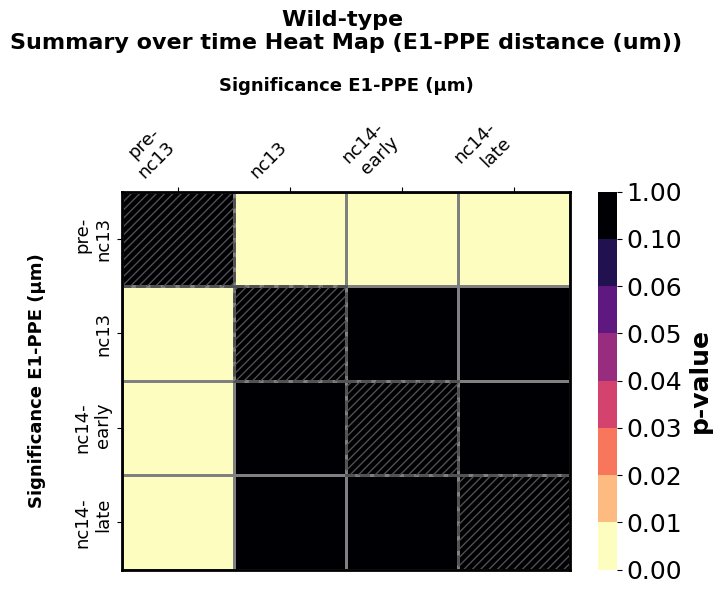

In [36]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    dataframes_2=[YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E1-PPE (μm)",
    y_axis_label="Significance E1-PPE (μm)"
)

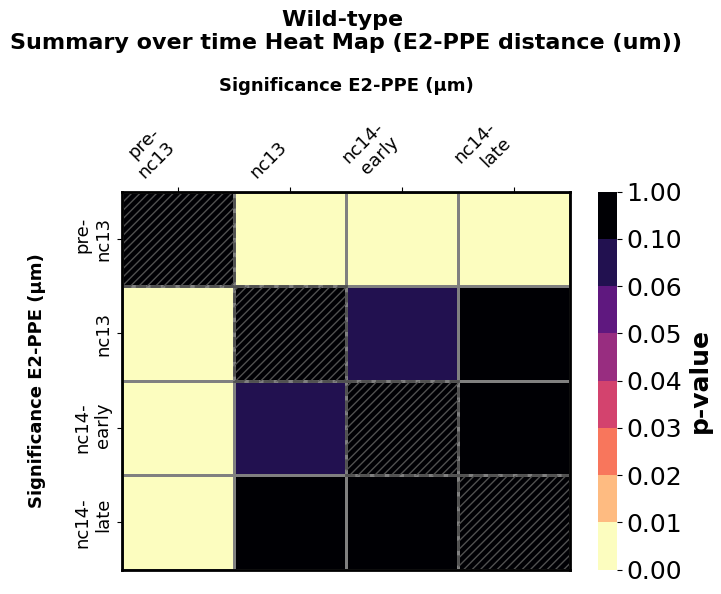

In [37]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    dataframes_2=[YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E2-PPE (μm)",
    y_axis_label="Significance E2-PPE (μm)"
)

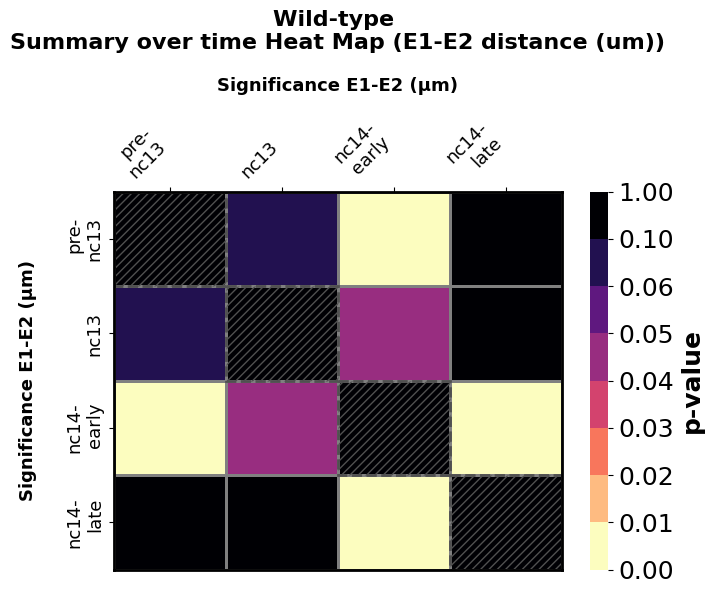

In [38]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    dataframes_2=[YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Wild-type \nSummary over time Heat Map",
    x_axis_label="Significance E1-E2 (μm)",
    y_axis_label="Significance E1-E2 (μm)"
)

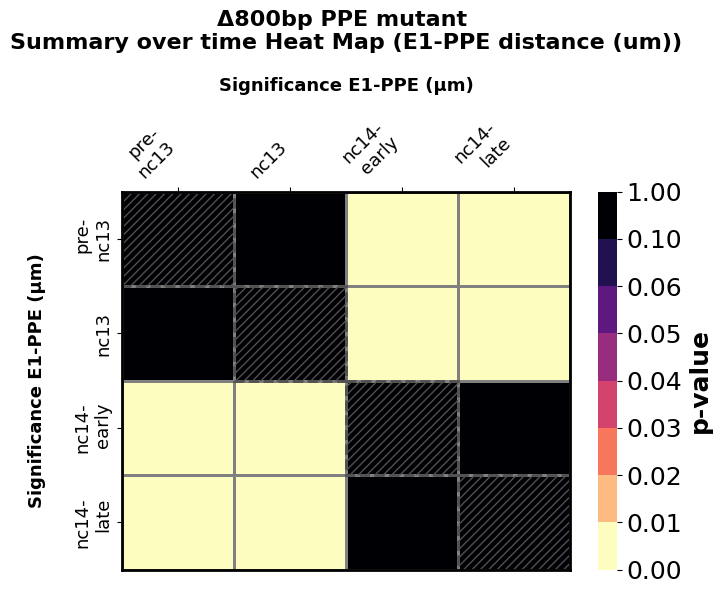

In [39]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    dataframes_2=[PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-PPE distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E1-PPE (μm)",
    y_axis_label="Significance E1-PPE (μm)"
)

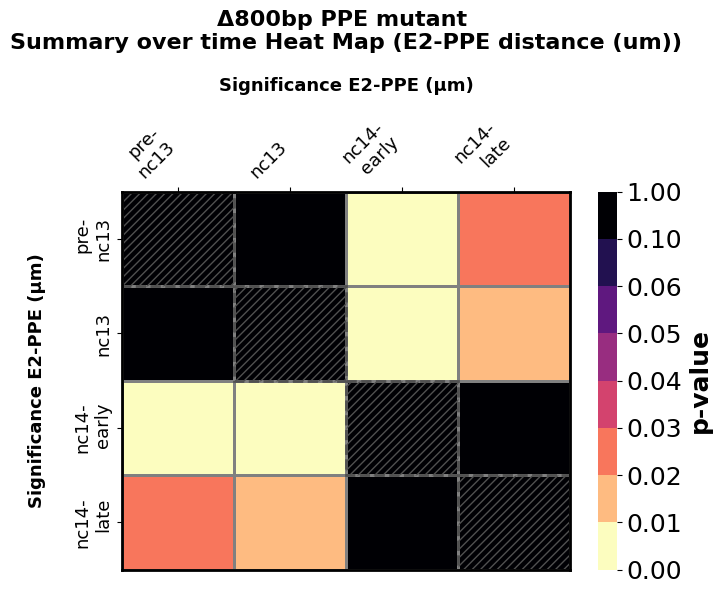

In [40]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    dataframes_2=[PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E2-PPE distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E2-PPE (μm)",
    y_axis_label="Significance E2-PPE (μm)"
)

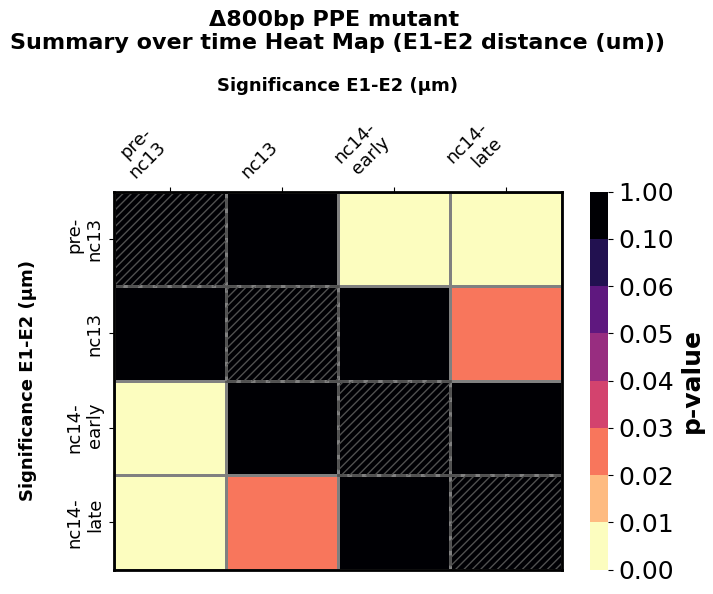

In [41]:
generate_pvalue_heatmap_strict_individual_side(
    dataframes_1=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    dataframes_2=[PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late],
    stages_labels=["pre-\nnc13", "nc13", "nc14-\nearly", "nc14-\nlate"],
    distance_column="E1-E2 distance (um)",
    title="Δ800bp PPE mutant \nSummary over time Heat Map",
    x_axis_label="Significance E1-E2 (μm)",
    y_axis_label="Significance E1-E2 (μm)"
)

# Section V: PDF generation for mutant and wild-type comparison

Comparison PDFs between wildtype and two mutants in Figure S3, S4 are generated. 

In [42]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Legend, LegendItem, HoverTool
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp
from bokeh.io import output_notebook  # Import for inline display

output_notebook()  # Ensure inline plotting in Jupyter

def generate_pdf_comparison_mutant(sample1_dataframe, sample2_dataframe, distance_column, title_prefix, sample1_name, sample1_color, sample2_name, sample2_color):
    """
    Generate a PDF comparison plot for 2 samples adaptable name and color.
    """

    def preprocess_data(data):
        """Drop NaN values and add small jitter if necessary."""
        data = data.dropna().to_numpy()
        
        # If the data has very few unique values, add jitter
        if np.unique(data).size < 5:
            data += np.random.normal(0, 1e-3, size=data.shape)  # Small noise
        
        return data

    # Convert DataFrames to NumPy arrays
    sample1_data = preprocess_data(sample1_dataframe[distance_column])
    sample2_data = preprocess_data(sample2_dataframe[distance_column])

    # Create the PDF plot
    pdf_plot = figure(
        title=f"{title_prefix} - PDF of {distance_column}",
        x_axis_label=distance_column, y_axis_label="Density",
        tools="pan,wheel_zoom,box_zoom,reset", height=500, width=1000, x_range=(-0.5, 3.5)
    )

    n_bootstraps = 1000  # Number of bootstrap samples

    def calculate_kde_and_ci(data, x_vals):
        """Compute KDE and confidence intervals using bootstrapping."""
        kde = gaussian_kde(data)
        y_vals = kde(x_vals)

        # Bootstrap for confidence intervals
        bootstrapped = np.array([
            gaussian_kde(np.random.choice(data, size=len(data), replace=True))(x_vals)
            for _ in range(n_bootstraps)
        ])
        ci_lower = np.percentile(bootstrapped, 2.5, axis=0)
        ci_upper = np.percentile(bootstrapped, 97.5, axis=0)

        return y_vals, ci_lower, ci_upper

    x_vals = np.linspace(min(sample1_data.min(), sample2_data.min()),
                         max(sample1_data.max(), sample2_data.max()), 100)

    # Calculate KDE and CI for each dataset
    y_sample1, ci_lower_sample1, ci_upper_sample1 = calculate_kde_and_ci(sample1_data, x_vals)
    y_sample2, ci_lower_sample2, ci_upper_sample2 = calculate_kde_and_ci(sample2_data, x_vals)

    # Calculate medians and number of data points
    median_sample1, median_sample2 = np.median(sample1_data), np.median(sample2_data)
    n_sample1, n_sample2 = len(sample1_data), len(sample2_data)
    
    # Customize title and axes for boldness and larger font sizes
    pdf_plot.title.text_font_size = "13pt"  # Larger font for the title
    pdf_plot.title.align = "center"  # Center align the title
    pdf_plot.axis.axis_label_text_font_size = "25pt"  # Larger font size for axis labels
    pdf_plot.axis.axis_label_text_font_style = "bold"  # Bold axis labels
    pdf_plot.axis.major_label_text_font_size = "18pt"  # Larger font size for tick labels
    pdf_plot.axis.major_label_text_font_style = "bold"  # Bold tick labels
    pdf_plot.axis.axis_line_width = 2  # Thicker axis lines
    pdf_plot.axis.axis_line_color = "black"  # Darker axis lines for emphasis
    pdf_plot.axis.major_tick_line_width = 3  # Thicker major ticks
    pdf_plot.axis.major_tick_line_color = "black"  # Darker major ticks
    pdf_plot.axis.minor_tick_line_width = 2  # Optionally thicker minor ticks
    pdf_plot.axis.minor_tick_line_color = "black"  # Optionally make minor ticks visible
    pdf_plot.title.standoff = 20  # Move the title higher from the graph (adjust as needed)
    

    # Function to add sample1 glyphs
    def add_sample1_glyphs(pdf_plot, x_vals, y_vals, ci_lower, ci_upper, sample1_name, color, n_sample1, median_sample1): 
        """ Creating mutant PDF with shaded confidence intervals. """
        source_sample1 = ColumnDataSource(data={'x':x_vals, 'y':y_vals, 'ci_lower':ci_lower, 'ci_upper':ci_upper})
        
        # Line and shading for mutant: 
        line_sample1 = pdf_plot.line('x','y', source=source_sample1, line_width=3, color=color, name=sample1_name)
        area_sample1 = pdf_plot.varea(x='x', y1='ci_lower', y2='ci_upper', source=source_sample1, fill_alpha=0.25, fill_color=color)

        # Create legend item with adaptable name
        legend_sample1 = LegendItem(label=f"{sample1_name} \n(n={n_sample1}, median={median_sample1:.2f})", renderers=[line_sample1, area_sample1])
        
        return line_sample1, area_sample1, legend_sample1
    
    # Adding mutant glyphs dynamically
    _, _, legend_sample1 = add_sample1_glyphs(
        pdf_plot, x_vals, y_sample1, ci_lower_sample1, ci_upper_sample1,
        sample1_name, sample1_color, n_sample1, median_sample1
    )
    
    # Function to add sample2 glyphs
    def add_sample2_glyphs(pdf_plot, x_vals, y_vals, ci_lower, ci_upper, sample2_name, color, n_sample2, median_sample2): 
        """ Creating mutant PDF with shaded confidence intervals. """
        source_sample2 = ColumnDataSource(data={'x':x_vals, 'y':y_vals, 'ci_lower':ci_lower, 'ci_upper':ci_upper})
        
        # Line and shading for mutant: 
        line_sample2 = pdf_plot.line('x','y', source=source_sample2, line_width=3, color=color, name=sample2_name)
        area_sample2 = pdf_plot.varea(x='x', y1='ci_lower', y2='ci_upper', source=source_sample2, fill_alpha=0.25, fill_color=color)

        # Create legend item with adaptable name
        legend_sample2 = LegendItem(label=f"{sample2_name} \n(n={n_sample2}, median={median_sample2:.2f})", renderers=[line_sample2, area_sample2])
        
        return line_sample2, area_sample2, legend_sample2
    
    #Adding mutant glyphs dynamically
    _, _, legend_sample2 = add_sample2_glyphs(
        pdf_plot, x_vals, y_sample2, ci_lower_sample2, ci_upper_sample2,
        sample2_name, sample2_color, n_sample2, median_sample2
    
    )
    # Compute min and max for median line range
    y_min_sample_1 = min(y_sample1)  # Smallest density value for sample 1 
    y_max_sample_1 = max(y_sample1)  # Largest density value for sample 1 

    y_min_sample_2 = min(y_sample2)  # Smallest density value for sample 2 
    y_max_sample_2 = max(y_sample2)  # Largest density value for sample 2 

    # Add median lines (dot-dashed) for sample 1 (YW)
    pdf_plot.line([median_sample1, median_sample1], [0, y_max_sample_1], 
                  line_width=2, color=sample1_color, line_dash="dotdash", line_alpha=0.4, 
                  )

    # Add median lines (dot-dashed) for sample 2 (PPE)
    pdf_plot.line([median_sample2, median_sample2], [0, y_max_sample_2], 
                  line_width=2, color=sample2_color, line_dash="dotdash", line_alpha=0.4, 
                  )

    # Add legends to the plot
    legend = Legend(items=[legend_sample1, legend_sample2])
    pdf_plot.add_layout(legend, 'right')
    pdf_plot.legend.click_policy = "hide"  # Interactive hiding

    # Hover tool
    pdf_plot.add_tools(HoverTool(tooltips=[("x", "$x"), ("y", "$y")]))

    # Perform K-S tests
    ks_pval = ks_2samp(sample1_data, sample2_data).pvalue
    print(f"K-S Test ({sample1_name} vs {sample2_name}): {ks_pval:.10f}")

    # Show the plot inline
    show(pdf_plot)

Loading BokehJS ...

### Comparing nc13 Wild-type and PPE Mutant. 

In [43]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc13,
    sample2_dataframe=PPE_E1_PPE_nc13,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc13",
    sample2_color = "#89CFF0"
)

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.0025520452


In [44]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc13,
    sample2_dataframe=PPE_E2_PPE_nc13,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc13",
    sample2_color = "#89CFF0"
)

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.0133833546


In [45]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc13,
    sample2_dataframe=PPE_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc13",
    sample1_name = "Wild-type control nc13",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc13",
    sample2_color = "#89CFF0"
)

K-S Test (Wild-type control nc13 vs Δ800PPE nc13): 0.7778180048


### Comparing nc14 late Wild-type and PPE Mutant. 

In [46]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_late,
    sample2_dataframe=PPE_E1_PPE_nc14_late,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14-late",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc14-late",
    sample2_color = "#007FFF"
)

K-S Test (Wild-type control nc14-late vs Δ800PPE nc14-late): 0.0000836718


In [47]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_late,
    sample2_dataframe=PPE_E2_PPE_nc14_late,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14-late",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc14-late",
    sample2_color = "#007FFF"
)

K-S Test (Wild-type control nc14-late vs Δ800PPE nc14-late): 0.4164983613


In [48]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_late,
    sample2_dataframe=PPE_E1_E2_nc14_late,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE for nc14 late",
    sample1_name = "Wild-type control nc14-late",
    sample1_color = "#4d004d",
    sample2_name = "Δ800PPE nc14-late",
    sample2_color = "#007FFF"
)

K-S Test (Wild-type control nc14-late vs Δ800PPE nc14-late): 0.0025454864


In [49]:
# Example usage
base_path = '../../../../02-11-25_MiMiC/Distances/'
stages = ['Nc14_late']

distance_data = extract_distances_from_folders(base_path,stages)

# Accessing the results for Nc14_late
mimic_insert_E2_PPE_nc14_late = distance_data['Nc14_late_E2-PPE']
mimic_insert_E1_PPE_nc14_late = distance_data['Nc14_late_E1-PPE']
mimic_insert_E1_E2_nc14_late = distance_data['Nc14_late_E1-E2']

In [50]:
# Example usage
base_path = '../../../../02-11-25_MiMiC/Distances/'
stages = ['Nc14_early']

distance_data = extract_distances_from_folders(base_path,stages)

# Accessing the results for Nc14_late
mimic_insert_E2_PPE_nc14_early = distance_data['Nc14_early_E2-PPE']
mimic_insert_E1_PPE_nc14_early = distance_data['Nc14_early_E1-PPE']
mimic_insert_E1_E2_nc14_early = distance_data['Nc14_early_E1-E2']

In [51]:
# Example usage
base_path = '../../../../02-11-25_MiMiC/Distances/'
stages = ['Nc13']

distance_data = extract_distances_from_folders(base_path,stages)

# Accessing the results for Nc14_late
mimic_insert_E2_PPE_nc13 = distance_data['Nc13_E2-PPE']
mimic_insert_E1_PPE_nc13 = distance_data['Nc13_E1-PPE']
mimic_insert_E1_E2_nc13 = distance_data['Nc13_E1-E2']

### Comparing nc14 late Wild-type and MiMIC Insertion Mutant. 

In [52]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_late,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.0726294654


In [53]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_late,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_late,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.1898731805


In [54]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_late,
    sample2_dataframe=mimic_insert_E1_E2_nc14_late,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 late",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.5767303017


### Comparing nc14 early Wild-type and MiMIC Insertion Mutant. 

In [55]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E1_PPE_nc14_early,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.1534403296


In [56]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc14_early,
    sample2_dataframe=mimic_insert_E2_PPE_nc14_early,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.0057921817


In [57]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc14_early,
    sample2_dataframe=mimic_insert_E1_E2_nc14_early,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc14 early",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.1953524294


### Comparing nc13 Wild-type and MiMIC Insertion Mutant. 

In [58]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_PPE_nc13,
    sample2_dataframe=mimic_insert_E1_PPE_nc13,
    distance_column="E1-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.0023283109


In [59]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E2_PPE_nc13,
    sample2_dataframe=mimic_insert_E2_PPE_nc13,
    distance_column="E2-PPE distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.0030297497


In [60]:
generate_pdf_comparison_mutant(
    sample1_dataframe=YW_E1_E2_nc13,
    sample2_dataframe=mimic_insert_E1_E2_nc13,
    distance_column="E1-E2 distance (um)",
    title_prefix="Comparison of YW, PPE, \nand MiMiC Insertion at 5' enhancer for nc13",
    sample1_name = "Wild-type control",
    sample1_color = "red",
    sample2_name = "MiMiC Insertion",
    sample2_color = "blue"
)

K-S Test (Wild-type control vs MiMiC Insertion): 0.6574173039


# Section VI: Heat map for wild-type and mutant comparison

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.colors import ListedColormap, BoundaryNorm

def format_p_value(p):
    """Format p-value: use scientific notation if p < 0.01, otherwise use decimal."""
    return f"{p:.3f}" if p >= 0.01 else f"{p:.1e}"

def generate_combined_pvalue_phenotype_heatmap(YW_dataframes, PPE_dataframes, stages_labels, distance_column, title_prefix):
    """
    Generate a single-row heatmap of p-values from Kolmogorov-Smirnov tests comparing anterior and posterior data across all stages.
    Color coding:
        - White if p > 0.05 (not significant).
        - Magenta if p ≤ 0.05 and median(PPE) > median(YW).
        - Cyan if p ≤ 0.05 and median(YW > PPE).

    Parameters:
        YW_dataframes (list of DataFrames): List of DataFrames containing anterior (YW) data.
        PPE_dataframes (list of DataFrames): List of DataFrames containing posterior (PPE) data.
        stages_labels (list of str): List of stage names.
        distance_column (str): The column name representing the distance to compare.
        title_prefix (str): Prefix for the title.

    Returns:
        None
    """
    # Initialize lists to store p-values, colors, and formatted labels
    p_values = []
    p_value_labels = []
    colors = []  
    color_labels = []  # Stores text labels for debugging

    for i, stage in enumerate(stages_labels):
        # Extract data for current stage
        YW_data = YW_dataframes[i][distance_column]
        PPE_data = PPE_dataframes[i][distance_column]

        # Perform Kolmogorov-Smirnov test
        _, p_value = ks_2samp(YW_data, PPE_data)
        p_values.append(p_value)
        p_value_labels.append(format_p_value(p_value))

        # Compute medians
        median_YW = np.median(YW_data)
        median_PPE = np.median(PPE_data)

        # Debugging printout for color logic
        print(f"Stage: {stage}, p-value: {p_value:.3f}, Median YW: {median_YW:.3f}, Median PPE: {median_PPE:.3f}")

        # Explicitly compare medians and ensure colors match correctly
        if p_value > 0.05:
            colors.append("#FFFFFF")  # White (not significant)
            color_labels.append("Not Significant")
        elif p_value <= 0.05 and median_YW > median_PPE:
            colors.append("#00FFFF")  # Cyan (YW > PPE) or (PPE < YW)
            color_labels.append("YW > PPE")
        elif p_value <= 0.05 and median_PPE > median_YW:
            colors.append("#FF00FF")  # Magenta (YW < PPE) or (PPE > YW)
            color_labels.append("PPE > YW")
        else:
            colors.append("#FFFFFF")  # White (backup, should never trigger)
            color_labels.append("Not Significant")

    # Debugging: Print assigned colors for each stage
    print("\nFinal Assigned Colors for Stages:")
    for stage, color, label in zip(stages_labels, colors, color_labels):
        print(f"{stage}: {label} ({color})")

    # Convert p-values into a DataFrame for heatmap
    p_value_matrix = np.array([p_values])
    p_value_df = pd.DataFrame(p_value_matrix, index=["YW vs. PPE"], columns=stages_labels)

    # Create a numerical color map (assigns numbers to colors)
    color_map_values = [0 if c == "#FFFFFF" else (1 if c == "#FF00FF" else 2) for c in colors]
    color_matrix = np.array([color_map_values])  # Reshape to match heatmap

    # Define a custom colormap with discrete colors
    custom_cmap = ListedColormap(["#FFFFFF", "#FF00FF", "#00FFFF"])
    norm = BoundaryNorm([0, 1, 2, 3], custom_cmap.N)  # ✅ Ensure `norm` is defined

    # Create the figure & plot heatmap
    fig, ax = plt.subplots(figsize=(8, 2))
    heatmap = sns.heatmap(
        color_matrix, annot=False, fmt="", linewidths=0.5, 
        cbar=True, annot_kws={"fontsize": 12}, cmap=custom_cmap, norm=norm,
        xticklabels=stages_labels, yticklabels=["YW vs. PPE"],
        vmin=0, vmax=2  # Ensures correct mapping of colors
    )

    # Customize colorbar labels
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([0.5, 1.5, 2.5])
    colorbar.set_ticklabels(["Not Significant", "Median mutant > Median wild-type \ncontrol", "Median mutant < Median \nwild-type control"])
    colorbar.ax.tick_params(labelsize=10)
    # Adjust color bar size (shrink = thickness, aspect = length)
    colorbar.ax.set_aspect(25)  # Increase height of colorbar
    colorbar.ax.figure.subplots_adjust(right=0.85)  # Adjust position to fit plot better

    # Formatting
    plt.title(f"{title_prefix} {distance_column}", fontsize=14, fontweight='bold', pad=10)
    plt.xticks(rotation=45, fontsize=12, ha='right')
    plt.yticks(fontsize=12)
    plt.xlabel("Stages", fontsize=12, fontweight='bold')
    plt.ylabel("", fontsize=12, fontweight='bold')  # Remove label since it's a single row

    # Adjust space between labels and plot
    plt.gcf().subplots_adjust(bottom=0.3, left=0.2)

    plt.show()

Stage: Before nc13, p-value: 0.136, Median YW: 0.645, Median PPE: 0.511
Stage: nc13, p-value: 0.013, Median YW: 0.403, Median PPE: 0.474
Stage: nc14 early, p-value: 0.997, Median YW: 0.383, Median PPE: 0.387
Stage: nc14 late, p-value: 0.416, Median YW: 0.413, Median PPE: 0.392

Final Assigned Colors for Stages:
Before nc13: Not Significant (#FFFFFF)
nc13: PPE > YW (#FF00FF)
nc14 early: Not Significant (#FFFFFF)
nc14 late: Not Significant (#FFFFFF)


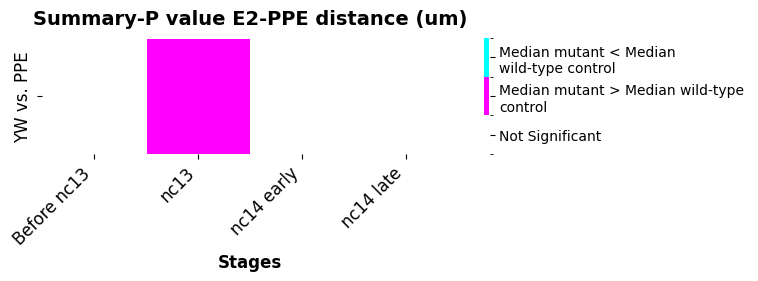

In [62]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E2_PPE_nc12, YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late]
ppe_data_sum = [PPE_E2_PPE_nc12, PPE_E2_PPE_nc13, PPE_E2_PPE_nc14_early, PPE_E2_PPE_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, ppe_data_sum, ["Before nc13", "nc13", "nc14 early", "nc14 late"],  "E2-PPE distance (um)","Summary-P value",
)

Stage: Before nc13, p-value: 0.101, Median YW: 0.381, Median PPE: 0.367
Stage: nc13, p-value: 0.003, Median YW: 0.308, Median PPE: 0.339
Stage: nc14 early, p-value: 0.099, Median YW: 0.304, Median PPE: 0.289
Stage: nc14 late, p-value: 0.000, Median YW: 0.322, Median PPE: 0.254

Final Assigned Colors for Stages:
Before nc13: Not Significant (#FFFFFF)
nc13: PPE > YW (#FF00FF)
nc14 early: Not Significant (#FFFFFF)
nc14 late: YW > PPE (#00FFFF)


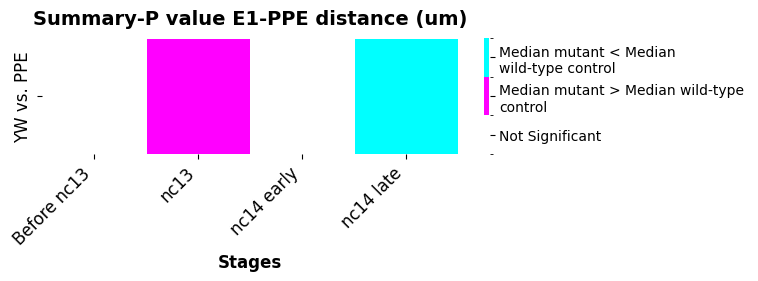

In [63]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E1_PPE_nc12, YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late]
ppe_data_sum = [PPE_E1_PPE_nc12, PPE_E1_PPE_nc13, PPE_E1_PPE_nc14_early, PPE_E1_PPE_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, ppe_data_sum, ["Before nc13", "nc13", "nc14 early", "nc14 late"],  "E1-PPE distance (um)","Summary-P value",
)

Stage: Before nc13, p-value: 0.894, Median YW: 0.505, Median PPE: 0.532
Stage: nc13, p-value: 0.778, Median YW: 0.403, Median PPE: 0.425
Stage: nc14 early, p-value: 0.532, Median YW: 0.350, Median PPE: 0.378
Stage: nc14 late, p-value: 0.003, Median YW: 0.427, Median PPE: 0.349

Final Assigned Colors for Stages:
Before nc13: Not Significant (#FFFFFF)
nc13: Not Significant (#FFFFFF)
nc14 early: Not Significant (#FFFFFF)
nc14 late: YW > PPE (#00FFFF)


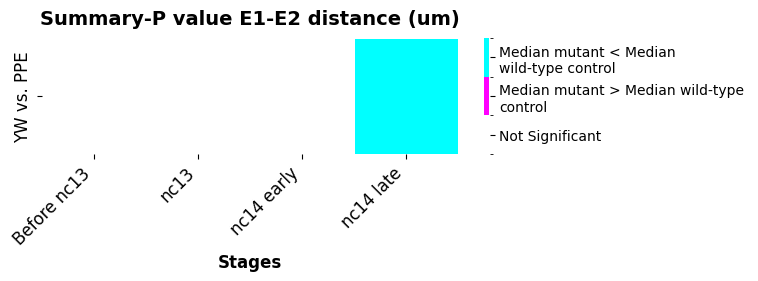

In [64]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E1_E2_nc12, YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late]
ppe_data_sum = [PPE_E1_E2_nc12, PPE_E1_E2_nc13, PPE_E1_E2_nc14_early, PPE_E1_E2_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, ppe_data_sum, ["Before nc13", "nc13", "nc14 early", "nc14 late"],  "E1-E2 distance (um)","Summary-P value",
)

Stage: nc13, p-value: 0.002, Median YW: 0.308, Median PPE: 0.335
Stage: nc14 early, p-value: 0.153, Median YW: 0.304, Median PPE: 0.289
Stage: nc14 late, p-value: 0.073, Median YW: 0.322, Median PPE: 0.302

Final Assigned Colors for Stages:
nc13: PPE > YW (#FF00FF)
nc14 early: Not Significant (#FFFFFF)
nc14 late: Not Significant (#FFFFFF)


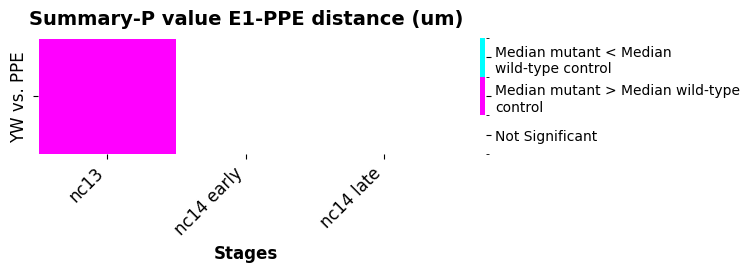

In [65]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E1_PPE_nc13, YW_E1_PPE_nc14_early, YW_E1_PPE_nc14_late]
mimic_data_sum = [mimic_insert_E1_PPE_nc13, mimic_insert_E1_PPE_nc14_early, mimic_insert_E1_PPE_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, mimic_data_sum, ["nc13", "nc14 early", "nc14 late"],  "E1-PPE distance (um)","Summary-P value",
)

Stage: nc13, p-value: 0.003, Median YW: 0.403, Median PPE: 0.310
Stage: nc14 early, p-value: 0.006, Median YW: 0.383, Median PPE: 0.320
Stage: nc14 late, p-value: 0.190, Median YW: 0.413, Median PPE: 0.424

Final Assigned Colors for Stages:
nc13: YW > PPE (#00FFFF)
nc14 early: YW > PPE (#00FFFF)
nc14 late: Not Significant (#FFFFFF)


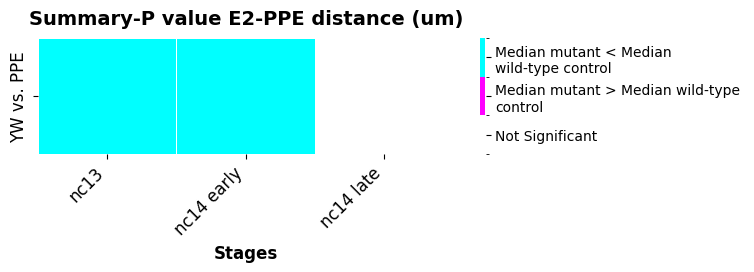

In [66]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E2_PPE_nc13, YW_E2_PPE_nc14_early, YW_E2_PPE_nc14_late]
mimic_data_sum = [mimic_insert_E2_PPE_nc13, mimic_insert_E2_PPE_nc14_early, mimic_insert_E2_PPE_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, mimic_data_sum, ["nc13", "nc14 early", "nc14 late"],  "E2-PPE distance (um)","Summary-P value",
)

Stage: nc13, p-value: 0.657, Median YW: 0.403, Median PPE: 0.387
Stage: nc14 early, p-value: 0.195, Median YW: 0.350, Median PPE: 0.404
Stage: nc14 late, p-value: 0.577, Median YW: 0.427, Median PPE: 0.468

Final Assigned Colors for Stages:
nc13: Not Significant (#FFFFFF)
nc14 early: Not Significant (#FFFFFF)
nc14 late: Not Significant (#FFFFFF)


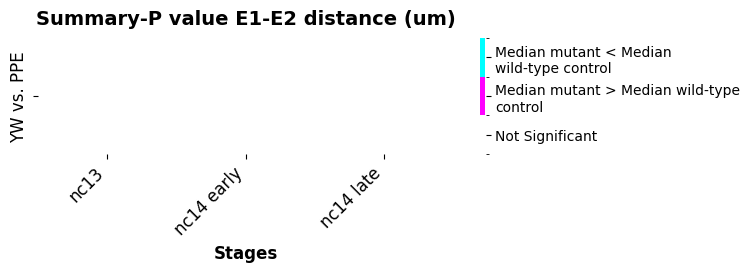

In [67]:
# Define anterior and posterior data lists
yw_data_sum = [YW_E1_E2_nc13, YW_E1_E2_nc14_early, YW_E1_E2_nc14_late]
mimic_data_sum = [mimic_insert_E1_E2_nc13, mimic_insert_E1_E2_nc14_early, mimic_insert_E1_E2_nc14_late]

# Generate a single heatmap for all stages
generate_combined_pvalue_phenotype_heatmap(
    yw_data_sum, mimic_data_sum, ["nc13", "nc14 early", "nc14 late"],  "E1-E2 distance (um)","Summary-P value",
)

# Section VII: Median triangles for wild-type and PPE mutant comparisons

In [68]:
import matplotlib.pyplot as plt

def enhance_plot_axis(ax, font_size=18, line_width=3):
    """
    Enhances the plot axis by increasing font size, bolding text, and thickening lines.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to modify.
        font_size (int): The size of the tick labels.
        line_width (int): The width of the axis lines.
    """
    # Set font size and bold text for axis labels and tick labels
    ax.xaxis.label.set_fontsize(font_size)
    ax.yaxis.label.set_fontsize(font_size)
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')
    
    ax.tick_params(axis='both', which='major', labelsize=font_size, width=line_width)
    
    # Increase axis line thickness
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)

In [69]:
def fill_region_between_sets(x1, y1, x2, y2, color='gray', alpha=0.3, ax=None, dashed=False):
    """
    Fills the region between two sets of points.
    """
    if ax is None:
        ax = plt.gca()
    
    for i in range(len(x1)):
        polygon = [[x1[i], y1[i]], [x2[i], y2[i]]]
        patch = patches.Polygon(polygon, closed=True, facecolor=color, alpha=alpha, edgecolor='black' if dashed else None, linestyle="--" if dashed else "-")
        ax.add_patch(patch)

def fill_region_to_point(x, y, x_base, y_base, color='gray', alpha=0.3, ax=None, dashed=False, label=None):
    """
    Fills the region between a set of points and a base point.
    """
    if ax is None:
        ax = plt.gca()
    
    for i in range(len(x)):
        polygon = [[x[i], y[i]], [x_base, y_base]]
        patch = patches.Polygon(polygon, closed=True, facecolor=color, alpha=alpha, edgecolor='black' if dashed else None, linestyle="--" if dashed else "-")
        ax.add_patch(patch)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

def calculate_triangle_vertices_OG(d1, d2, d3):
    """
    Calculate the vertices of a triangle in 2D space given three distances:
    d1, d2, and d3.

    Parameters:
        d1 (float): Distance between point A and point B.
        d2 (float): Distance between point B and point C.
        d3 (float): Distance between point A and point C.

    Returns:
        tuple: Three vertices of the triangle in 2D space as (A, B, C).
               Each vertex is a tuple (x, y).
    """
    if not (d1 + d2 > d3 and d1 + d3 > d2 and d2 + d3 > d1):
        raise ValueError("The provided distances do not form a valid triangle.")
    A = (0, 0)
    B = (d3, 0)
    x_C = (d3**2 + d2**2 - d1**2) / (2 * d3)
    y_C = np.sqrt(d2**2 - x_C**2)
    C = (x_C, y_C)
    return A, B, C

def compute_triangle_vertices_from_arrays(d1_arr, d2_arr, d3_arr):
    """
    For every combination of distances in d1_arr, d2_arr, and d3_arr,
    compute the triangle vertices using calculate_triangle_vertices_OG.
    
    Returns:
        x_coords: Array of shape (N, 3) with x-coordinates for vertices A, B, C.
        y_coords: Array of shape (N, 3) with y-coordinates for vertices A, B, C.
    """
    total_combinations = len(d1_arr) * len(d2_arr) * len(d3_arr)
    x_coords = np.zeros((total_combinations, 3))
    y_coords = np.zeros((total_combinations, 3))
    n = 0
    for i in range(len(d1_arr)):
        for j in range(len(d2_arr)):
            for k in range(len(d3_arr)):
                d1 = d1_arr[i]
                d2 = d2_arr[j]
                d3 = d3_arr[k]
                if not (d1 + d2 > d3 and d1 + d3 > d2 and d2 + d3 > d1):
                    continue
                A, B, C = calculate_triangle_vertices_OG(d1, d2, d3)
                x_coords[n, :] = [A[0], B[0], C[0]]
                y_coords[n, :] = [A[1], B[1], C[1]]
                n += 1
    x_coords = x_coords[:n, :]
    y_coords = y_coords[:n, :]
    return x_coords, y_coords

def fill_region_to_point(x_points, y_points, x_target, y_target, color, alpha=0.3, label=None, dashed=False):
    """
    Fill (shade) the region between candidate points (x_points, y_points) and
    a target point (x_target, y_target) by computing their convex hull.
    If dashed=True, a hatched (dashed-pattern) fill is applied.
    """
    pts = np.column_stack((x_points, y_points))
    pts = np.vstack((pts, [x_target, y_target]))
    if len(pts) < 3:
        return
    hull = ConvexHull(pts)
    hull_pts = pts[hull.vertices]
    hull_pts = np.vstack([hull_pts, hull_pts[0]])  # close polygon
    if dashed:
        patch = Polygon(hull_pts, closed=True, facecolor=color, edgecolor=color,
                        hatch='//', alpha=alpha, label=label)
        plt.gca().add_patch(patch)
    else:
        plt.fill(hull_pts[:, 0], hull_pts[:, 1], color=color, alpha=alpha, label=label)

def fill_region_between_sets(x1, y1, x2, y2, color, alpha=0.3, label=None, dashed=False):
    """
    Fill (shade) the region between two sets of candidate points.
    If dashed=True, a hatched (dashed-pattern) fill is applied.
    """
    pts1 = np.column_stack((x1, y1))
    pts2 = np.column_stack((x2, y2))
    pts = np.vstack((pts1, pts2))
    if len(pts) < 3:
        return
    hull = ConvexHull(pts)
    hull_pts = pts[hull.vertices]
    hull_pts = np.vstack([hull_pts, hull_pts[0]])
    if dashed:
        patch = Polygon(hull_pts, closed=True, facecolor=color, edgecolor=color,
                        hatch='//', alpha=alpha, label=label)
        plt.gca().add_patch(patch)
    else:
        plt.fill(hull_pts[:, 0], hull_pts[:, 1], color=color, alpha=alpha, label=label)

In [71]:
def plot_combined_stage(yw_median, yw_upper, yw_lower,
                        ppe_median, ppe_upper, ppe_lower,
                        title, show_legend=True, x_tick_limit=None, num_samples=10):
    """
    Plot a combined triangle representation for YW and PPE with median points, 
    shading regions, and annotations.
    """
    plt.figure(figsize=(10,10))  # Adjust width and height as needed

    # --- YW Group Candidate Points ---
    d1_arr_yw = np.linspace(yw_lower[0], yw_upper[0], num_samples)
    d2_arr_yw = np.linspace(yw_lower[1], yw_upper[1], num_samples)
    d3_arr_yw = np.linspace(yw_lower[2], yw_upper[2], num_samples)
    x_yw, y_yw = compute_triangle_vertices_from_arrays(d1_arr_yw, d2_arr_yw, d3_arr_yw)

    # --- PPE Group Candidate Points ---
    d1_arr_ppe = np.linspace(ppe_lower[0], ppe_upper[0], num_samples)
    d2_arr_ppe = np.linspace(ppe_lower[1], ppe_upper[1], num_samples)
    d3_arr_ppe = np.linspace(ppe_lower[2], ppe_upper[2], num_samples)
    x_ppe, y_ppe = compute_triangle_vertices_from_arrays(d1_arr_ppe, d2_arr_ppe, d3_arr_ppe)

    # --- Plot candidate points ---
    for i in range(x_yw.shape[0]):
        plt.plot(x_yw[i, 1], y_yw[i, 1], 'o', color='gray',markersize=4)  # Red dots (B) for YW
        plt.plot(x_yw[i, 2], y_yw[i, 2], 'o', color='gray', markersize=4)  # Black dots (C) for YW
    
    for i in range(x_ppe.shape[0]):
        plt.plot(x_ppe[i, 1], y_ppe[i, 1], 'o', color='#FF80FF', markersize=4)  # Red dots (B) for PPE
        plt.plot(x_ppe[i, 2], y_ppe[i, 2], 'o', color='#FF80FF', markersize=4)  # Magenta dots (C) for PPE
    
    # --- Shading Regions ---
    fill_region_to_point(x_yw[:, 2], y_yw[:, 2], 0, 0, color='lightgray', alpha=0.3, label="wild-type: PPE to E1 shading")
    fill_region_between_sets(x_yw[:, 2], y_yw[:, 2], x_yw[:, 1], y_yw[:, 1], color='lightgray', alpha=0.3, label="wild-type: PPE to E2 shading")
    fill_region_to_point(x_ppe[:, 2], y_ppe[:, 2], 0, 0, color='lightpink', alpha=0.3, label="PPE mutant: PPE to E1 shading", dashed=True)
    fill_region_between_sets(x_ppe[:, 2], y_ppe[:, 2], x_ppe[:, 1], y_ppe[:, 1], color='lightpink', alpha=0.3, label="PPE: PPE to E2 shading", dashed=True)

    # --- Median Triangles ---
    A_yw, B_yw, C_yw = calculate_triangle_vertices_OG(*yw_median)
    A_ppe, B_ppe, C_ppe = calculate_triangle_vertices_OG(*ppe_median)

    plt.plot([A_yw[0], B_yw[0], C_yw[0], A_yw[0]],
             [A_yw[1], B_yw[1], C_yw[1], A_yw[1]],
             color='black', linewidth=2, label='wild-type median')
    plt.plot([A_ppe[0], B_ppe[0], C_ppe[0], A_ppe[0]],
             [A_ppe[1], B_ppe[1], C_ppe[1], A_ppe[1]],
             color='#DA70D6', linestyle='--', linewidth=2, label='PPE median')

    # --- Median Dots ---
    plt.plot(0, 0, 'o', color='blue', markersize=12, label='E1')  # A (0,0)
    plt.plot(C_yw[0], C_yw[1], 'o', color='green', markersize=12, label='PPE')
    plt.plot(C_ppe[0], C_ppe[1], 'o', color='green', markersize=12, label='PPE ')

    # --- Large Red Dot at the Median 3' Enhancer Position ---
    plt.plot(B_yw[0], B_yw[1], 'o', color='red', markersize=12, label="E2 ")
    plt.plot(B_ppe[0], B_ppe[1], 'o', color='red', markersize=12, label="E2 ")

    # --- Formatting ---
    if x_tick_limit is not None:
        plt.xlim(-0.2, x_tick_limit)
    else:
        plt.xlim(-0.2, 1.35)
    plt.ylim(-0.1, 0.45)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(fontsize=9, fontweight='bold')
    plt.yticks(fontsize=9, fontweight='bold')
    plt.grid(True)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)  # Hide gridlines
    enhance_plot_axis(ax, font_size=18, line_width=3)

    if show_legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title="Legend")

    plt.show()

In [72]:
YW_sem_nc12_E2_PPE = YW_nc12_std_E2_PPE / np.sqrt(len((YW_E2_PPE_nc12)))
YW_sem_nc13_E2_PPE = YW_nc13_std_E2_PPE / np.sqrt(len((YW_E2_PPE_nc13)))
YW_sem_nc14_early_E2_PPE = YW_nc14_early_std_E2_PPE / np.sqrt(len((YW_E2_PPE_nc14_early)))
YW_sem_nc14_late_E2_PPE = YW_nc14_late_std_E2_PPE / np.sqrt(len((YW_E2_PPE_nc14_late)))

YW_sem_nc12_E1_PPE = YW_nc12_std_E1_PPE / np.sqrt(len((YW_E1_PPE_nc12)))
YW_sem_nc13_E1_PPE = YW_nc13_std_E1_PPE / np.sqrt(len((YW_E1_PPE_nc13)))
YW_sem_nc14_early_E1_PPE = YW_nc14_early_std_E1_PPE / np.sqrt(len((YW_E1_PPE_nc14_early)))
YW_sem_nc14_late_E1_PPE = YW_nc14_late_std_E1_PPE / np.sqrt(len((YW_E1_PPE_nc14_late)))

YW_sem_nc12_E1_E2 = YW_nc12_std_E1_E2 / np.sqrt(len((YW_E1_E2_nc12)))
YW_sem_nc13_E1_E2 = YW_nc13_std_E1_E2 / np.sqrt(len((YW_E1_E2_nc13)))
YW_sem_nc14_early_E1_E2 = YW_nc14_early_std_E1_E2 / np.sqrt(len((YW_E1_E2_nc14_early)))
YW_sem_nc14_early_E1_E2 = YW_nc14_late_std_E1_E2 / np.sqrt(len((YW_E1_E2_nc14_late)))

In [73]:
YW_nc12_E2_PPE_large_median = YW_nc12_median_E2_PPE + YW_sem_nc12_E2_PPE
YW_nc13_E2_PPE_large_median = YW_nc13_median_E2_PPE + YW_sem_nc13_E2_PPE
YW_nc14_early_E2_PPE_large_median = YW_nc14_early_median_E2_PPE + YW_sem_nc14_early_E2_PPE
YW_nc14_late_E2_PPE_large_median = YW_nc14_late_median_E2_PPE + YW_sem_nc14_late_E2_PPE

YW_nc12_E1_PPE_large_median = YW_nc12_median_E1_PPE + YW_sem_nc12_E1_PPE
YW_nc13_E1_PPE_large_median = YW_nc13_median_E1_PPE + YW_sem_nc13_E1_PPE
YW_nc14_early_E1_PPE_large_median = YW_nc14_early_median_E1_PPE + YW_sem_nc14_early_E1_PPE
YW_nc14_late_E1_PPE_large_median = YW_nc14_late_median_E1_PPE + YW_sem_nc14_late_E1_PPE

YW_nc12_E1_E2_large_median = YW_nc12_median_E1_E2 + YW_sem_nc12_E1_E2
YW_nc13_E1_E2_large_median = YW_nc13_median_E1_E2 + YW_sem_nc13_E1_E2
YW_nc14_early_E1_E2_large_median = YW_nc14_early_median_E1_E2 + YW_sem_nc14_early_E1_E2
YW_nc14_late_E1_E2_large_median = YW_nc14_late_median_E1_E2 + YW_sem_nc14_early_E1_E2

In [74]:
YW_nc12_E2_PPE_small_median = YW_nc12_median_E2_PPE - YW_sem_nc12_E2_PPE
YW_nc13_E2_PPE_small_median = YW_nc13_median_E2_PPE - YW_sem_nc13_E2_PPE
YW_nc14_early_E2_PPE_small_median = YW_nc14_early_median_E2_PPE - YW_sem_nc14_early_E2_PPE
YW_nc14_late_E2_PPE_small_median = YW_nc14_late_median_E2_PPE - YW_sem_nc14_late_E2_PPE

YW_nc12_E1_PPE_small_median = YW_nc12_median_E1_PPE - YW_sem_nc12_E1_PPE
YW_nc13_E1_PPE_small_median = YW_nc13_median_E1_PPE - YW_sem_nc13_E1_PPE
YW_nc14_early_E1_PPE_small_median =  YW_nc14_early_median_E1_PPE - YW_sem_nc14_early_E1_PPE
YW_nc14_late_E1_PPE_small_median = YW_nc14_late_median_E1_PPE - YW_sem_nc14_late_E1_PPE

YW_nc12_E1_E2_small_median = YW_nc12_median_E1_E2 - YW_sem_nc12_E1_E2
YW_nc13_E1_E2_small_median = YW_nc13_median_E1_E2 - YW_sem_nc13_E1_E2
YW_nc14_early_E1_E2_small_median = YW_nc14_early_median_E1_E2 - YW_sem_nc14_early_E1_E2
YW_nc14_late_E1_E2_small_median = YW_nc14_late_median_E1_E2 - YW_sem_nc14_early_E1_E2

In [75]:
PPE_sem_nc12_E2_PPE = PPE_nc12_std_E2_PPE / np.sqrt(len((PPE_E2_PPE_nc12)))
PPE_sem_nc13_E2_PPE = PPE_nc13_std_E2_PPE / np.sqrt(len((PPE_E2_PPE_nc13)))
PPE_sem_nc14_early_E2_PPE = PPE_nc14_early_std_E2_PPE / np.sqrt(len((PPE_E2_PPE_nc14_early)))
PPE_sem_nc14_late_E2_PPE = PPE_nc14_late_std_E2_PPE / np.sqrt(len((PPE_E2_PPE_nc14_late)))

PPE_sem_nc12_E1_PPE = PPE_nc12_std_E1_PPE / np.sqrt(len((PPE_E1_PPE_nc12)))
PPE_sem_nc13_E1_PPE = PPE_nc13_std_E1_PPE / np.sqrt(len((PPE_E1_PPE_nc13)))
PPE_sem_nc14_early_E1_PPE = PPE_nc14_early_std_E1_PPE / np.sqrt(len((PPE_E1_PPE_nc14_early)))
PPE_sem_nc14_late_E1_PPE = PPE_nc14_late_std_E1_PPE / np.sqrt(len((PPE_E1_PPE_nc14_late)))

PPE_sem_nc12_E1_E2 = PPE_nc12_std_E1_E2 / np.sqrt(len((PPE_E1_E2_nc12)))
PPE_sem_nc13_E1_E2 = PPE_nc13_std_E1_E2 / np.sqrt(len((PPE_E1_E2_nc13)))
PPE_sem_nc14_early_E1_E2 = PPE_nc14_early_std_E1_E2 / np.sqrt(len((PPE_E1_E2_nc14_early)))
PPE_sem_nc14_late_E1_E2 = PPE_nc14_late_std_E1_E2 / np.sqrt(len((PPE_E1_E2_nc14_late)))

In [76]:
PPE_nc12_E2_PPE_large_median = PPE_nc12_median_PPE_E2_PPE + PPE_sem_nc12_E2_PPE
PPE_nc13_E2_PPE_large_median = PPE_nc13_median_PPE_E2_PPE + PPE_sem_nc13_E2_PPE
PPE_nc14_early_E2_PPE_large_median = PPE_nc14_early_median_PPE_E2_PPE + PPE_sem_nc14_early_E2_PPE
PPE_nc14_late_E2_PPE_large_median = PPE_nc14_late_median_PPE_E2_PPE + PPE_sem_nc14_late_E2_PPE 

PPE_nc12_E1_PPE_large_median = PPE_nc12_median_PPE_E1_PPE + PPE_sem_nc12_E1_PPE
PPE_nc13_E1_PPE_large_median = PPE_nc13_median_PPE_E1_PPE + PPE_sem_nc13_E1_PPE
PPE_nc14_early_E1_PPE_large_median = PPE_nc14_early_median_PPE_E1_PPE + PPE_sem_nc14_early_E1_PPE
PPE_nc14_late_E1_PPE_large_median = PPE_nc14_late_median_PPE_E1_PPE + PPE_sem_nc14_late_E1_PPE

PPE_nc12_E1_E2_large_median = PPE_nc12_median_PPE_E1_E2 + PPE_sem_nc12_E1_E2
PPE_nc13_E1_E2_large_median = PPE_nc13_median_PPE_E1_E2 + PPE_sem_nc13_E1_E2
PPE_nc14_early_E1_E2_large_median = PPE_nc14_early_median_PPE_E1_E2 + PPE_sem_nc14_early_E1_E2
PPE_nc14_late_E1_E2_large_median = PPE_nc14_late_median_PPE_E1_E2 + PPE_sem_nc14_late_E1_E2

In [77]:
PPE_nc12_E2_PPE_small_median = PPE_nc12_median_PPE_E2_PPE - PPE_sem_nc12_E2_PPE
PPE_nc13_E2_PPE_small_median = PPE_nc13_median_PPE_E2_PPE - PPE_sem_nc13_E2_PPE
PPE_nc14_early_E2_PPE_small_median = PPE_nc14_early_median_PPE_E2_PPE - PPE_sem_nc14_early_E2_PPE
PPE_nc14_late_E2_PPE_small_median = PPE_nc14_late_median_PPE_E2_PPE - PPE_sem_nc14_late_E2_PPE 

PPE_nc12_E1_PPE_small_median = PPE_nc12_median_PPE_E1_PPE - PPE_sem_nc12_E1_PPE
PPE_nc13_E1_PPE_small_median = PPE_nc13_median_PPE_E1_PPE - PPE_sem_nc13_E1_PPE
PPE_nc14_early_E1_PPE_small_median = PPE_nc14_early_median_PPE_E1_PPE - PPE_sem_nc14_early_E1_PPE
PPE_nc14_late_E1_PPE_small_median = PPE_nc14_late_median_PPE_E1_PPE - PPE_sem_nc14_late_E1_PPE

PPE_nc12_E1_E2_small_median = PPE_nc12_median_PPE_E1_E2 - PPE_sem_nc12_E1_E2
PPE_nc13_E1_E2_small_median = PPE_nc13_median_PPE_E1_E2 - PPE_sem_nc13_E1_E2
PPE_nc14_early_E1_E2_small_median = PPE_nc14_early_median_PPE_E1_E2 - PPE_sem_nc14_early_E1_E2
PPE_nc14_late_E1_E2_small_median = PPE_nc14_late_median_PPE_E1_E2 - PPE_sem_nc14_early_E1_E2

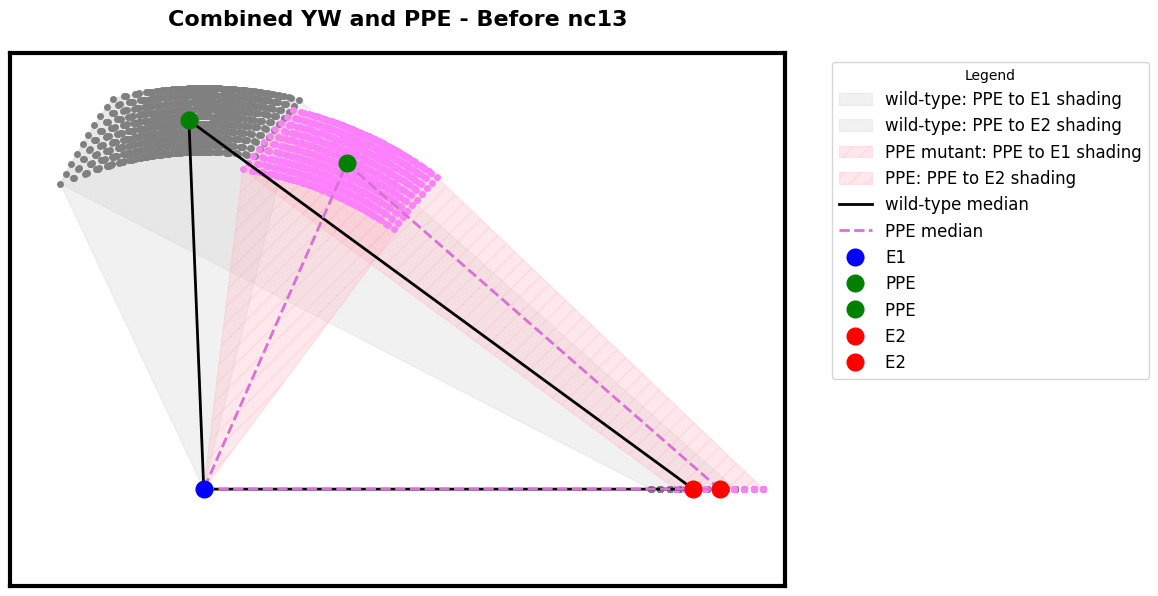

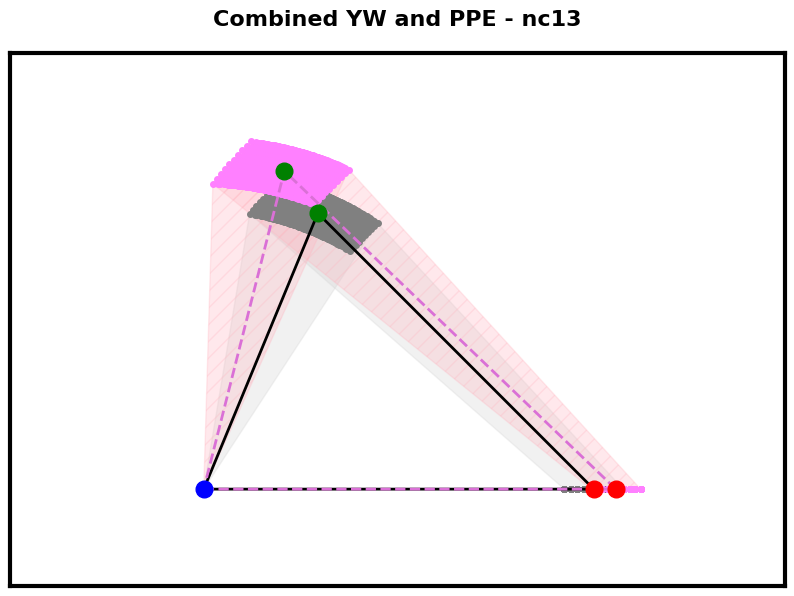

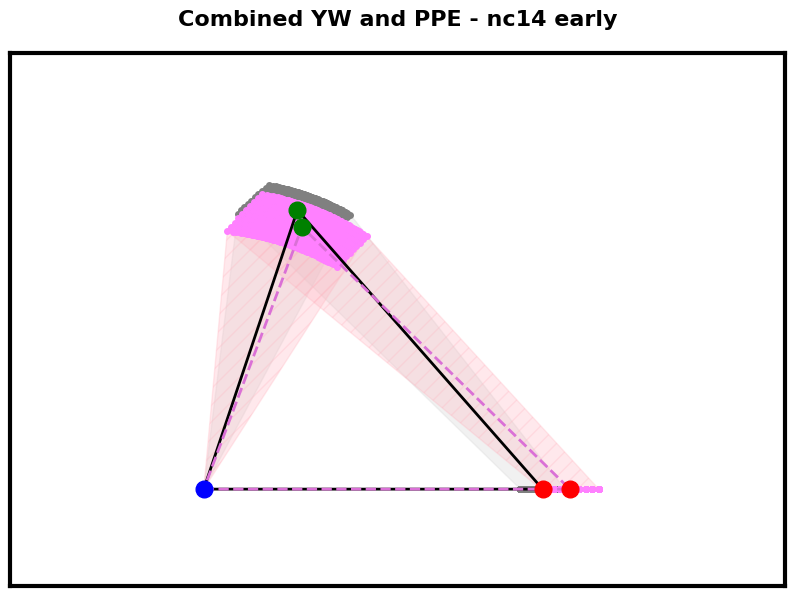

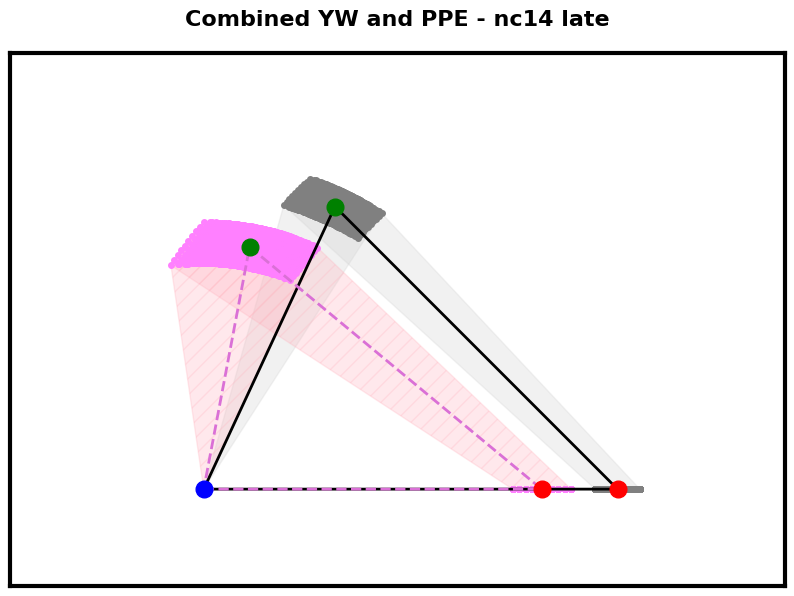

In [78]:
# Plot combined YW and PPE mutant for different stages
plot_combined_stage(
    (YW_nc12_median_E2_PPE, YW_nc12_median_E1_PPE, YW_nc12_median_E1_E2),
    (YW_nc12_E2_PPE_large_median, YW_nc12_E1_PPE_large_median, YW_nc12_E1_E2_large_median),
    (YW_nc12_E2_PPE_small_median, YW_nc12_E1_PPE_small_median, YW_nc12_E1_E2_small_median),
    (PPE_nc12_median_PPE_E2_PPE, PPE_nc12_median_PPE_E1_PPE, PPE_nc12_median_PPE_E1_E2),
    (PPE_nc12_E2_PPE_large_median, PPE_nc12_E1_PPE_large_median, PPE_nc12_E1_E2_large_median),
    (PPE_nc12_E2_PPE_small_median, PPE_nc12_E1_PPE_small_median, PPE_nc12_E1_E2_small_median),
    "Combined YW and PPE - Before nc13", x_tick_limit=0.6
)

plot_combined_stage(
    (YW_nc13_median_E2_PPE, YW_nc13_median_E1_PPE, YW_nc13_median_E1_E2),
    (YW_nc13_E2_PPE_large_median, YW_nc13_E1_PPE_large_median, YW_nc13_E1_E2_large_median),
    (YW_nc13_E2_PPE_small_median, YW_nc13_E1_PPE_small_median, YW_nc13_E1_E2_small_median),
    (PPE_nc13_median_PPE_E2_PPE, PPE_nc13_median_PPE_E1_PPE, PPE_nc13_median_PPE_E1_E2),
    (PPE_nc13_E2_PPE_large_median, PPE_nc13_E1_PPE_large_median, PPE_nc13_E1_E2_large_median),
    (PPE_nc13_E2_PPE_small_median, PPE_nc13_E1_PPE_small_median, PPE_nc13_E1_E2_small_median),
    "Combined YW and PPE - nc13", x_tick_limit=0.6, show_legend = False
)

plot_combined_stage(
    (YW_nc14_early_median_E2_PPE, YW_nc14_early_median_E1_PPE, YW_nc14_early_median_E1_E2),
    (YW_nc14_early_E2_PPE_large_median, YW_nc14_early_E1_PPE_large_median, YW_nc14_early_E1_E2_large_median),
    (YW_nc14_early_E2_PPE_small_median, YW_nc14_early_E1_PPE_small_median, YW_nc14_early_E1_E2_small_median),
    (PPE_nc14_early_median_PPE_E2_PPE, PPE_nc14_early_median_PPE_E1_PPE, PPE_nc14_early_median_PPE_E1_E2),
    (PPE_nc14_early_E2_PPE_large_median, PPE_nc14_early_E1_PPE_large_median, PPE_nc14_early_E1_E2_large_median),
    (PPE_nc14_early_E2_PPE_small_median, PPE_nc14_early_E1_PPE_small_median, PPE_nc14_early_E1_E2_small_median),
    "Combined YW and PPE - nc14 early", x_tick_limit=0.6, show_legend = False
)

plot_combined_stage(
    (YW_nc14_late_median_E2_PPE, YW_nc14_late_median_E1_PPE, YW_nc14_late_median_E1_E2),
    (YW_nc14_late_E2_PPE_large_median, YW_nc14_late_E1_PPE_large_median, YW_nc14_late_E1_E2_large_median),
    (YW_nc14_late_E2_PPE_small_median, YW_nc14_late_E1_PPE_small_median, YW_nc14_late_E1_E2_small_median),
    (PPE_nc14_late_median_PPE_E2_PPE, PPE_nc14_late_median_PPE_E1_PPE, PPE_nc14_late_median_PPE_E1_E2),
    (PPE_nc14_late_E2_PPE_large_median, PPE_nc14_late_E1_PPE_large_median, PPE_nc14_late_E1_E2_large_median),
    (PPE_nc14_late_E2_PPE_small_median, PPE_nc14_late_E1_PPE_small_median, PPE_nc14_late_E1_E2_small_median),
    "Combined YW and PPE - nc14 late", x_tick_limit=0.6, show_legend = False
)

In [79]:
mimic_nc13_std_E2_PPE = np.std(mimic_insert_E2_PPE_nc13["E2-PPE distance (um)"])
mimic_nc14_early_std_E2_PPE = np.std(mimic_insert_E2_PPE_nc14_early["E2-PPE distance (um)"])
mimic_nc14_late_std_E2_PPE = np.std(mimic_insert_E2_PPE_nc14_late["E2-PPE distance (um)"])

mimic_nc13_std_E1_PPE = np.std(mimic_insert_E1_PPE_nc13["E1-PPE distance (um)"])
mimic_nc14_early_std_E1_PPE = np.std(mimic_insert_E1_PPE_nc14_early["E1-PPE distance (um)"])
mimic_nc14_late_std_E1_PPE = np.std(mimic_insert_E1_PPE_nc14_late["E1-PPE distance (um)"])

mimic_nc13_std_E1_E2 = np.std(mimic_insert_E1_E2_nc13["E1-E2 distance (um)"])
mimic_nc14_early_std_E1_E2 = np.std(mimic_insert_E1_E2_nc14_early["E1-E2 distance (um)"])
mimic_nc14_late_std_E1_E2 = np.std(mimic_insert_E1_E2_nc14_late["E1-E2 distance (um)"])

In [80]:
mimic_nc13_median_E2_PPE = np.median(mimic_insert_E2_PPE_nc13["E2-PPE distance (um)"])
mimic_nc14_early_median_E2_PPE = np.median(mimic_insert_E2_PPE_nc14_early["E2-PPE distance (um)"])
mimic_nc14_late_median_E2_PPE = np.median(mimic_insert_E2_PPE_nc14_late["E2-PPE distance (um)"])

mimic_nc13_median_E1_PPE = np.median(mimic_insert_E1_PPE_nc13["E1-PPE distance (um)"])
mimic_nc14_early_median_E1_PPE = np.median(mimic_insert_E1_PPE_nc14_early["E1-PPE distance (um)"])
mimic_nc14_late_median_E1_PPE = np.median(mimic_insert_E1_PPE_nc14_late["E1-PPE distance (um)"])

mimic_nc13_median_E1_E2 = np.median(mimic_insert_E1_E2_nc13["E1-E2 distance (um)"])
mimic_nc14_early_median_E1_E2 = np.median(mimic_insert_E1_E2_nc14_early["E1-E2 distance (um)"])
mimic_nc14_late_median_E1_E2 = np.median(mimic_insert_E1_E2_nc14_late["E1-E2 distance (um)"])

In [81]:
mimic_sem_nc13_E2_PPE = mimic_nc13_std_E2_PPE / np.sqrt(len((mimic_insert_E2_PPE_nc13)))
mimic_sem_nc14_early_E2_PPE = mimic_nc14_early_std_E2_PPE / np.sqrt(len((mimic_insert_E2_PPE_nc14_early)))
mimic_sem_nc14_late_E2_PPE = mimic_nc14_late_std_E2_PPE / np.sqrt(len((mimic_insert_E2_PPE_nc14_late)))

mimic_sem_nc13_E1_PPE = mimic_nc13_std_E1_PPE / np.sqrt(len((mimic_insert_E1_PPE_nc13)))
mimic_sem_nc14_early_E1_PPE = mimic_nc14_early_std_E1_PPE / np.sqrt(len((mimic_insert_E1_PPE_nc14_early)))
mimic_sem_nc14_late_E1_PPE = mimic_nc14_late_std_E1_PPE / np.sqrt(len((mimic_insert_E1_PPE_nc14_late)))

mimic_sem_nc13_E1_E2 = mimic_nc13_std_E1_E2 / np.sqrt(len((mimic_insert_E1_E2_nc13)))
mimic_sem_nc14_early_E1_E2 = mimic_nc14_early_std_E1_E2 / np.sqrt(len((mimic_insert_E1_E2_nc14_early)))
mimic_sem_nc14_early_E1_E2 = mimic_nc14_late_std_E1_E2 / np.sqrt(len((mimic_insert_E1_E2_nc14_late)))

In [82]:
mimic_nc13_E2_PPE_large_median = mimic_nc13_median_E2_PPE + mimic_sem_nc13_E2_PPE
mimic_nc14_early_E2_PPE_large_median = mimic_nc14_early_median_E2_PPE + mimic_sem_nc14_early_E2_PPE
mimic_nc14_late_E2_PPE_large_median = mimic_nc14_late_median_E2_PPE + mimic_sem_nc14_late_E2_PPE

mimic_nc13_E1_PPE_large_median = mimic_nc13_median_E1_PPE + mimic_sem_nc13_E1_PPE
mimic_nc14_early_E1_PPE_large_median = mimic_nc14_early_median_E1_PPE + mimic_sem_nc14_early_E1_PPE
mimic_nc14_late_E1_PPE_large_median = mimic_nc14_late_median_E1_PPE + mimic_sem_nc14_late_E1_PPE

mimic_nc13_E1_E2_large_median = mimic_nc13_median_E1_E2 + mimic_sem_nc13_E1_E2
mimic_nc14_early_E1_E2_large_median = mimic_nc14_early_median_E1_E2 + mimic_sem_nc14_early_E1_E2
mimic_nc14_late_E1_E2_large_median = mimic_nc14_late_median_E1_E2 + mimic_sem_nc14_early_E1_E2

In [83]:
mimic_nc13_E2_PPE_small_median = mimic_nc13_median_E2_PPE - mimic_sem_nc13_E2_PPE
mimic_nc14_early_E2_PPE_small_median = mimic_nc14_early_median_E2_PPE - mimic_sem_nc14_early_E2_PPE
mimic_nc14_late_E2_PPE_small_median = mimic_nc14_late_median_E2_PPE - mimic_sem_nc14_late_E2_PPE

mimic_nc13_E1_PPE_small_median = mimic_nc13_median_E1_PPE - mimic_sem_nc13_E1_PPE
mimic_nc14_early_E1_PPE_small_median =  mimic_nc14_early_median_E1_PPE - mimic_sem_nc14_early_E1_PPE
mimic_nc14_late_E1_PPE_small_median = mimic_nc14_late_median_E1_PPE - mimic_sem_nc14_late_E1_PPE

mimic_nc13_E1_E2_small_median = mimic_nc13_median_E1_E2 - mimic_sem_nc13_E1_E2
mimic_nc14_early_E1_E2_small_median = mimic_nc14_early_median_E1_E2 - mimic_sem_nc14_early_E1_E2
mimic_nc14_late_E1_E2_small_median = mimic_nc14_late_median_E1_E2 - mimic_sem_nc14_early_E1_E2

In [84]:
def plot_combined_stage_mimic(yw_median, yw_upper, yw_lower,
                        mimic_median, mimic_upper, mimic_lower,
                        title, show_legend=True, x_tick_limit=None, num_samples=10):
    """
    Plot a combined triangle representation for YW and PPE with median points, 
    shading regions, and annotations.
    """
    plt.figure(figsize=(10,10))  # Adjust width and height as needed

    # --- YW Group Candidate Points ---
    d1_arr_yw = np.linspace(yw_lower[0], yw_upper[0], num_samples)
    d2_arr_yw = np.linspace(yw_lower[1], yw_upper[1], num_samples)
    d3_arr_yw = np.linspace(yw_lower[2], yw_upper[2], num_samples)
    x_yw, y_yw = compute_triangle_vertices_from_arrays(d1_arr_yw, d2_arr_yw, d3_arr_yw)

    # --- MiMIC Group Candidate Points ---
    d1_arr_mimic = np.linspace(mimic_lower[0], mimic_upper[0], num_samples)
    d2_arr_mimic = np.linspace(mimic_lower[1], mimic_upper[1], num_samples)
    d3_arr_mimic = np.linspace(mimic_lower[2], mimic_upper[2], num_samples)
    x_mimic, y_mimic = compute_triangle_vertices_from_arrays(d1_arr_mimic, d2_arr_mimic, d3_arr_mimic)
    
    # --- Plot candidate points FIRST ---
    for i in range(x_yw.shape[0]):
        plt.plot(x_yw[i, 1], y_yw[i, 1], 'o', color='gray', markersize=4)  
        plt.plot(x_yw[i, 2], y_yw[i, 2], 'o', color='gray', markersize=4)  
    
    for i in range(x_mimic.shape[0]):
        plt.plot(x_mimic[i, 1], y_mimic[i, 1], 'o', color='#FFB347', markersize=4)  
        plt.plot(x_mimic[i, 2], y_mimic[i, 2], 'o', color='#FFB347', markersize=4)  

    # --- Median Triangles (Ensure they are on top of candidate points) ---
    A_yw, B_yw, C_yw = calculate_triangle_vertices_OG(*yw_median)
    A_mimic, B_mimic, C_mimic = calculate_triangle_vertices_OG(*mimic_median)

    plt.plot([A_yw[0], B_yw[0], C_yw[0], A_yw[0]],
             [A_yw[1], B_yw[1], C_yw[1], A_yw[1]],
             color='black', linewidth=2, label='YW median', zorder=3)  # Ensure it's above
    plt.plot([A_mimic[0], B_mimic[0], C_mimic[0], A_mimic[0]],
             [A_mimic[1], B_mimic[1], C_mimic[1], A_mimic[1]],
             color='#CC5500', linestyle='--', linewidth=2, label='MiMiC median', zorder=3)

    # --- Shading Regions (Plotted Last to Ensure Visibility) ---
    fill_region_to_point(x_yw[:, 2], y_yw[:, 2], 0, 0, color='lightgray', alpha=0.2, label="wild-type: PPE to E1 shading")
    fill_region_between_sets(x_yw[:, 2], y_yw[:, 2], x_yw[:, 1], y_yw[:, 1], color='lightgray', alpha=0.3, label="wild-type: PPE to E2 shading")
    fill_region_to_point(x_mimic[:, 2], y_mimic[:, 2], 0, 0, color='#FFDAB9', alpha=0.2, label="MiMiC Insertion: PPE to E1 shading", dashed=True)
    fill_region_between_sets(x_mimic[:, 2], y_mimic[:, 2], x_mimic[:, 1], y_mimic[:, 1], color='#FFDAB9', alpha=0.3, label="PPE: PPE to E2 shading", dashed=True)

    # --- Median Dots (Ensure they are on top) ---
    plt.plot(0, 0, 'o', color='blue', markersize=12, label='E1', zorder=4)  
    plt.plot(C_yw[0], C_yw[1], 'o', color='green', markersize=12, label='PPE', zorder=4)
    plt.plot(C_mimic[0], C_mimic[1], 'o', color='green', markersize=12, label='PPE ', zorder=4)

    # --- Large Red Dot at the Median 3' Enhancer Position ---
    plt.plot(B_yw[0], B_yw[1], 'o', color='red', markersize=12, label="E2 ", zorder=4)
    plt.plot(B_mimic[0], B_mimic[1], 'o', color='red', markersize=12, label="E2 ", zorder=4)

    # --- Formatting ---
    if x_tick_limit is not None:
        plt.xlim(-0.2, x_tick_limit)
    else:
        plt.xlim(-0.2, 1.35)
    plt.ylim(-0.1, 0.45)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(fontsize=9, fontweight='bold')
    plt.yticks(fontsize=9, fontweight='bold')

    # --- Hide Axes & Grid ---
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)  # Hide gridlines
    enhance_plot_axis(ax, font_size=18, line_width=3)

    if show_legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title="Legend")

    plt.show()

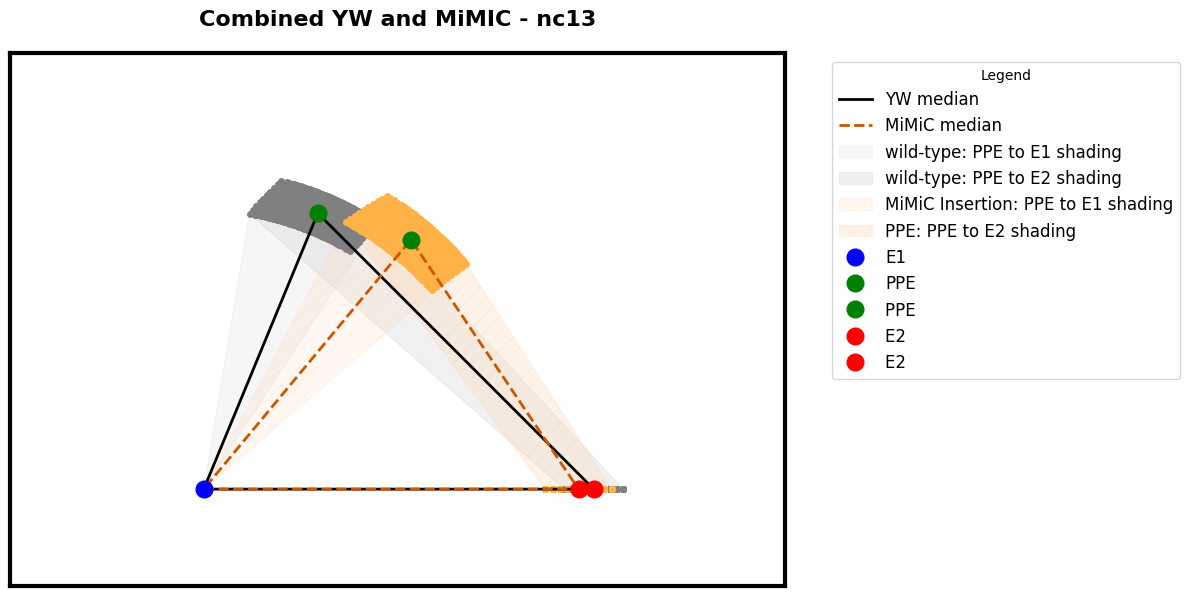

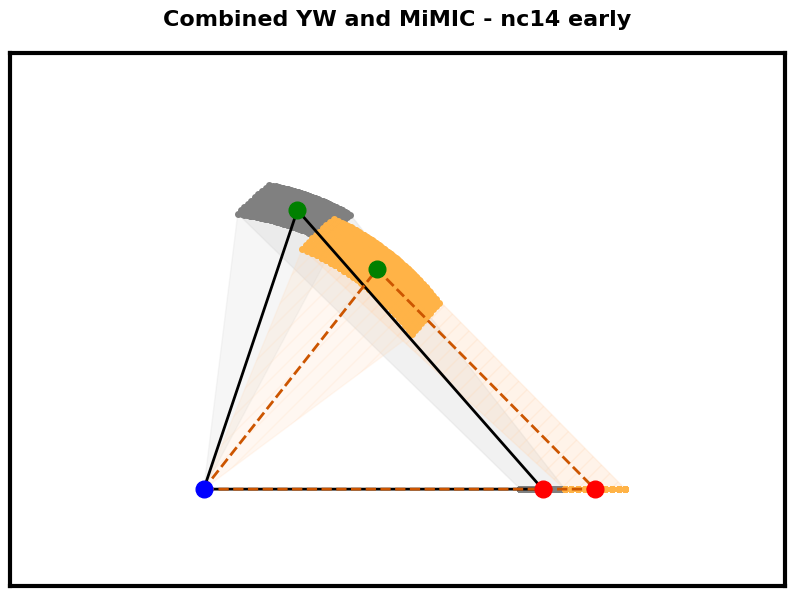

In [ ]:
# Plot combined YW and PPE mutant for different stages
plot_combined_stage_mimic(
    (YW_nc13_median_E2_PPE, YW_nc13_median_E1_PPE, YW_nc13_median_E1_E2),
    (YW_nc13_E2_PPE_large_median, YW_nc13_E1_PPE_large_median, YW_nc13_E1_E2_large_median),
    (YW_nc13_E2_PPE_small_median, YW_nc13_E1_PPE_small_median, YW_nc13_E1_E2_small_median),
    (mimic_nc13_median_E2_PPE, mimic_nc13_median_E1_PPE, mimic_nc13_median_E1_E2),
    (mimic_nc13_E2_PPE_large_median, mimic_nc13_E1_PPE_large_median, mimic_nc13_E1_E2_large_median),
    (mimic_nc13_E2_PPE_small_median, mimic_nc13_E1_PPE_small_median, mimic_nc13_E1_E2_small_median),
    "Combined YW and MiMIC - nc13", x_tick_limit=0.6
)

plot_combined_stage_mimic(
    (YW_nc14_early_median_E2_PPE, YW_nc14_early_median_E1_PPE, YW_nc14_early_median_E1_E2),
    (YW_nc14_early_E2_PPE_large_median, YW_nc14_early_E1_PPE_large_median, YW_nc14_early_E1_E2_large_median),
    (YW_nc14_early_E2_PPE_small_median, YW_nc14_early_E1_PPE_small_median, YW_nc14_early_E1_E2_small_median),
    (mimic_nc14_early_median_E2_PPE, mimic_nc14_early_median_E1_PPE, mimic_nc14_early_median_E1_E2),
    (mimic_nc14_early_E2_PPE_large_median, mimic_nc14_early_E1_PPE_large_median, mimic_nc14_early_E1_E2_large_median),
    (mimic_nc14_early_E2_PPE_small_median, mimic_nc14_early_E1_PPE_small_median, mimic_nc14_early_E1_E2_small_median),
    "Combined YW and MiMIC - nc14 early", x_tick_limit=0.6, show_legend = False
)

plot_combined_stage_mimic(
    (YW_nc14_late_median_E2_PPE, YW_nc14_late_median_E1_PPE, YW_nc14_late_median_E1_E2),
    (YW_nc14_late_E2_PPE_large_median, YW_nc14_late_E1_PPE_large_median, YW_nc14_late_E1_E2_large_median),
    (YW_nc14_late_E2_PPE_small_median, YW_nc14_late_E1_PPE_small_median, YW_nc14_late_E1_E2_small_median),
    (mimic_nc14_late_median_E2_PPE, mimic_nc14_late_median_E1_PPE, mimic_nc14_late_median_E1_E2),
    (mimic_nc14_late_E2_PPE_large_median, mimic_nc14_late_E1_PPE_large_median, mimic_nc14_late_E1_E2_large_median),
    (mimic_nc14_late_E2_PPE_small_median, mimic_nc14_late_E1_PPE_small_median, mimic_nc14_late_E1_E2_small_median),
    "Combined YW and MiMIC - nc14 late", x_tick_limit=0.6, show_legend = False
)